<div style="border-radius:10px;
    border:#410159 solid;
    background-color:#fef1ff;
    font-size:110%;
    letter-spacing:0.5px;
    text-align: center">
<center><h1 style="padding: 25px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Home credit default risk</h1></center>
<center><h3 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">With Boosting models</h3></center>
<center><h4 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">(Modelisation)</h4></center>
</div>

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
To view EDA for this case, please refer to the notebook exploration 1&2</div>

#### After a careful study and consideration of all given files and the goal of the problem, we can notice that most files contain info about the previous loans, which means if we depend on these info, our model will struggle in generalization with new clients with no previous loans experience or info, so we will try to make the best use of only application info to make a model can generalize well.

In [1]:
import os
for dirname, _, filenames in os.walk(r'C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\application_test.csv
C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\application_train.csv
C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\application_train_join.csv
C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\bureau.csv
C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\bureau_balance.csv
C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\credit_card_balance.csv
C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\HomeCredit_columns_description.csv
C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\installments_payments.csv
C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\POS_CASH_balance.csv
C:\Users\Sofia\OneDrive\Documents\Open

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pandas import MultiIndex, Int64Index

# ----------------------------------------------------
import sklearn
import scipy
import statsmodels.api as sm 
from scipy.stats import shapiro
import pickle
from sklearn import metrics

# ----------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import pycaret
from pycaret.classification import *

# ----------------------------------------------------
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# ----------------------------------------------------
from sklearn.metrics import auc, roc_curve, roc_auc_score
from collections import Counter

from sklearn.metrics import confusion_matrix, recall_score, fbeta_score, precision_score, average_precision_score
from sklearn.metrics import f1_score, accuracy_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_validate
import outils_model

import mlflow
import mlflow.sklearn

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
import time

# Versions
print('Version des librairies utilisées :')


print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__ )

C:\Users\Sofia\AppData\Local\Temp\ipykernel_15812\2944410620.py:6: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Version des librairies utilisées :
NumPy                 : 1.22.3
Pandas                : 1.4.4
Seaborn               : 0.12.0
Sklearn               : 1.1.2


In [3]:
# Changement de l'affichage

pd.set_option('display.max_row',200)
pd.set_option('display.max_column',200)
pd.set_option('display.precision', 5)
pd.set_option('display.max_colwidth', None)

# Define functions

In [4]:
# Detection d'outliers : 
# valeurs inférieurs au quartiles1 -1.5 ecart-interquartiles
# valeurs supérieurs au quartiles3 +1.5 ecart-interquartiles
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------------------
# retourne les outliers "inférieur"
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------------------
# retourne les outliers "supérieur"
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------------------
# Affiche le nombre d'outliers "inf"&"sup" par colonne
# Affiche boxplot et density graph par colonne
def preprocess(df, col):
    print("*********************** {} ***********************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()

# ----------------------------------------------------------
# Affiche barplot de chaque occurence par colonne
def preprocess_cat(df, col):
    print("******************** {} ********************\n".format(col))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.show()
    
# ----------------------------------------------------------
# Remplace les outliers "sup" par la valeur du 3eme quartile +1.5*ecart interquartile
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)

# ----------------------------------------------------------
# Remplace les outliers "inf" par la valeur du 1eme quartile -1.5*ecart interquartile
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# ----------------------------------------------------------
# Remplace les valeurs Nan par le mode
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])
    print("NaN in {} raplaced with {}".format(col, df[col].mode()[0]))

# ----------------------------------------------------------
# Remplace les valeurs Nan par la moyenne
def replace_mean(df, col):
    df[col] = df[col].fillna(df[col].mean())
    print("NaN in {} raplaced with {}".format(col, df[col].mean()))
    
# ----------------------------------------------------------
# Remplace les valeurs Nan par la médiane
def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    print("NaN in {} raplaced with {}".format(col, df[col].median()))
    

# ----------------------------------------------------------
# Stratified K-Folds cross-validator
# Provides train/test indices to split data in train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds. 
# The folds are made by preserving the percentage of samples for each class
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Fonction, qui en fonction du model, renvoie le resultats roc_auc moyen avec une validation croisé
def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())
    
# ----------------------------------------------------------
# Fonction utilisant un RandomizeSearchCV, en fonction du model, renvoie le meilleur score, estimator et param
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

# Data Understanding

In [5]:
# Chargement des fichier train&test
train = pd.read_csv(r"C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\application_train.csv")
test = pd.read_csv(r"C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\home-credit-default-risk\application_test.csv")
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01880,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08304,0.26295,0.13938,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.00354,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31127,0.62225,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01003,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.55591,0.72957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

0    282686
1     24825
Name: TARGET, dtype: int64

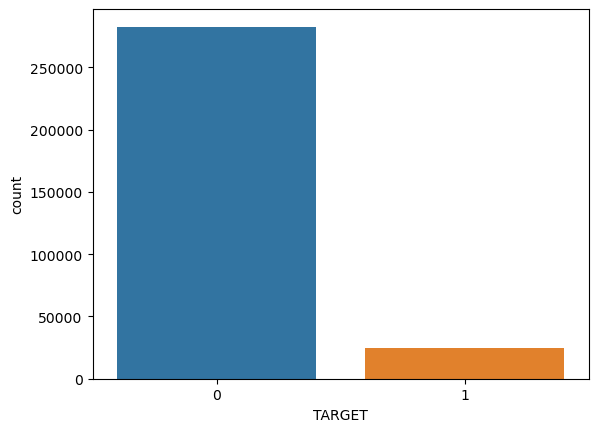

In [6]:
# Valeurs distincts pour la variable TARGET
sns.countplot(x = "TARGET", data = train)
train.loc[:, 'TARGET'].value_counts()

#### On remarque un gros déséquilibre entre les classes. La classe 0 est majoritaire et represente, plus de 90%. Il faudra prendre cela en compte lors de la partie modélisation.

In [7]:
# Info des tables train&test
print(train.info())
print("*******************************")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
*******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


In [8]:
# Affichage du describe de la table train
pd.set_option('display.max_rows', train.shape[0])
train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,2.78181e+05,102790.17535,1.00002e+05,189145.50000,278202.00000,367142.50000,4.56255e+05
TARGET,307511.0,8.07288e-02,0.27242,0.00000e+00,0.00000,0.00000,0.00000,1.00000e+00
CNT_CHILDREN,307511.0,4.17052e-01,0.72212,0.00000e+00,0.00000,0.00000,1.00000,1.90000e+01
AMT_INCOME_TOTAL,307511.0,1.68798e+05,237123.14628,2.56500e+04,112500.00000,147150.00000,202500.00000,1.17000e+08
AMT_CREDIT,307511.0,5.99026e+05,402490.77700,4.50000e+04,270000.00000,513531.00000,808650.00000,4.05000e+06
AMT_ANNUITY,307499.0,2.71086e+04,14493.73732,1.61550e+03,16524.00000,24903.00000,34596.00000,2.58026e+05
AMT_GOODS_PRICE,307233.0,5.38396e+05,369446.46054,4.05000e+04,238500.00000,450000.00000,679500.00000,4.05000e+06
REGION_POPULATION_RELATIVE,307511.0,2.08681e-02,0.01383,2.90000e-04,0.01001,0.01885,0.02866,7.25080e-02
DAYS_BIRTH,307511.0,-1.60370e+04,4363.98863,-2.52290e+04,-19682.00000,-15750.00000,-12413.00000,-7.48900e+03
DAYS_EMPLOYED,307511.0,6.38150e+04,141275.76652,-1.79120e+04,-2760.00000,-1213.00000,-289.00000,3.65243e+05


In [9]:
# Affichage du nombre de valeurs Nan par colonne
pd.DataFrame(train.isnull().sum().sort_values(ascending = False))

,0
COMMONAREA_MEDI,214865
COMMONAREA_AVG,214865
COMMONAREA_MODE,214865
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_AVG,213514
NONLIVINGAPARTMENTS_MEDI,213514
FONDKAPREMONT_MODE,210295
LIVINGAPARTMENTS_MODE,210199
LIVINGAPARTMENTS_AVG,210199
LIVINGAPARTMENTS_MEDI,210199


In [10]:
# Affichage du nombre de valeurs Nan par colonne
pd.DataFrame(test.isnull().sum().sort_values(ascending = False))

,0
COMMONAREA_AVG,33495
COMMONAREA_MODE,33495
COMMONAREA_MEDI,33495
NONLIVINGAPARTMENTS_AVG,33347
NONLIVINGAPARTMENTS_MODE,33347
NONLIVINGAPARTMENTS_MEDI,33347
FONDKAPREMONT_MODE,32797
LIVINGAPARTMENTS_AVG,32780
LIVINGAPARTMENTS_MODE,32780
LIVINGAPARTMENTS_MEDI,32780


# Preprocessing

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
1. Numerical Field</h3>
</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Missing Data</h3></center>
</div>

In [11]:
# Valeur équivalente à 60% de la longueur du dataset
threshold_train = len(train) * 0.60
int(threshold_train)

184506

In [12]:
# Valeur équivalente à 60% de la longueur du dataset
threshold_test = len(test) * 0.60
int(threshold_test)

29246

In [13]:
# Affichage des colonnes par dataset ayant plus de 60% de valeurs Nan
print("In train data:\n")
print(train.columns[train.isnull().sum() > int(threshold_train)])
print("******************************************")
print("In test data:\n")
print(test.columns[test.isnull().sum() > int(threshold_test)])

In train data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')
******************************************
In test data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')


In [14]:
# Suppressions des colonnes ayant plus de 60% de valeurs Nan
train_new = train.dropna(axis='columns', thresh=threshold_train)
print(train_new.shape)
print("******************************************")
test_new = test.dropna(axis='columns', thresh=threshold_test)
print(test_new.shape)

(307511, 73)
******************************************
(48744, 72)


In [15]:
# Variables quantitatives
numeric_feature = train_new.dtypes!=object
final_numeric_feature = train_new.columns[numeric_feature].tolist()

#----------------------------------------------------
numeric_feature_test = test_new.dtypes!=object
final_numeric_feature_test = test_new.columns[numeric_feature_test].tolist()

In [16]:
# Dataset avec les varibales quantitatives
numeric = train_new[final_numeric_feature]

#-------------------------------------------
numeric_test = test_new[final_numeric_feature_test]
numeric.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.01880,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.26295,0.13938,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.00354,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.62225,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.01003,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.55591,0.72957,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.00802,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.65044,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.02866,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.32274,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Valeurs quantitatives discrètes (int)
discrete_features = numeric.dtypes!=float
final_discrete_feature = numeric.columns[discrete_features].tolist()
discrete = numeric[final_discrete_feature]

#-------------------------------------------
discrete_features_test = numeric_test.dtypes!=float
final_discrete_feature_test = numeric_test.columns[discrete_features_test].tolist()
discrete_test = numeric_test[final_discrete_feature_test]

discrete.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,0,-9461,-637,-2120,1,1,0,1,1,0,2,2,10,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,-16765,-1188,-291,1,1,0,1,1,0,1,1,11,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,-19046,-225,-2531,1,1,1,1,1,0,2,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,-19005,-3039,-2437,1,1,0,1,0,0,2,2,17,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,-19932,-3038,-3458,1,1,0,1,0,0,2,2,11,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# Nombre de valeurs Nan par variable quantitatives discrete
pd.DataFrame(discrete.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
FLAG_DOCUMENT_2,0
FLAG_DOCUMENT_4,0
FLAG_DOCUMENT_5,0
FLAG_DOCUMENT_6,0
FLAG_DOCUMENT_7,0
FLAG_DOCUMENT_8,0
FLAG_DOCUMENT_9,0
FLAG_DOCUMENT_10,0
FLAG_DOCUMENT_11,0


In [19]:
pd.DataFrame(discrete_test.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
CNT_CHILDREN,0
FLAG_DOCUMENT_4,0
FLAG_DOCUMENT_5,0
FLAG_DOCUMENT_6,0
FLAG_DOCUMENT_7,0
FLAG_DOCUMENT_8,0
FLAG_DOCUMENT_9,0
FLAG_DOCUMENT_10,0
FLAG_DOCUMENT_11,0


In [20]:
# Valeurs quantitatives continue (float)
continuous_features = numeric.dtypes==float
final_continuous_feature = numeric.columns[continuous_features].tolist()
continuous = numeric[final_continuous_feature]

#-------------------------------------------
continuous_features_test = numeric_test.dtypes==float
final_continuous_feature_test = numeric_test.columns[continuous_features_test].tolist()
continuous_test = numeric_test[final_continuous_feature_test]

continuous.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,202500.0,406597.5,24700.5,351000.0,0.01880,-3648.0,1.0,0.26295,0.13938,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,270000.0,1293502.5,35698.5,1129500.0,0.00354,-1186.0,2.0,0.62225,NaN,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67500.0,135000.0,6750.0,135000.0,0.01003,-4260.0,1.0,0.55591,0.72957,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,135000.0,312682.5,29686.5,297000.0,0.00802,-9833.0,2.0,0.65044,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,121500.0,513000.0,21865.5,513000.0,0.02866,-4311.0,1.0,0.32274,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Nombre de valeurs Nan par variable quantitatives continue
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,60965
AMT_REQ_CREDIT_BUREAU_YEAR,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_HOUR,41519
OBS_60_CNT_SOCIAL_CIRCLE,1021
DEF_60_CNT_SOCIAL_CIRCLE,1021
DEF_30_CNT_SOCIAL_CIRCLE,1021


In [22]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,8668
AMT_REQ_CREDIT_BUREAU_YEAR,6049
AMT_REQ_CREDIT_BUREAU_QRT,6049
AMT_REQ_CREDIT_BUREAU_MON,6049
AMT_REQ_CREDIT_BUREAU_WEEK,6049
AMT_REQ_CREDIT_BUREAU_DAY,6049
AMT_REQ_CREDIT_BUREAU_HOUR,6049
OBS_60_CNT_SOCIAL_CIRCLE,29
DEF_60_CNT_SOCIAL_CIRCLE,29
DEF_30_CNT_SOCIAL_CIRCLE,29


In [23]:
# Colonnes des variables quantitatives continue
continuous_col = continuous.columns

In [24]:
# 1er quartile pour chaque colonne
Q1 = train_new.quantile(0.25)

# 3eme quartile pour chaque colonne
Q3 = train_new.quantile(0.75)

# Ecart interquartiles
IQR = Q3 - Q1

*********************** AMT_INCOME_TOTAL ***********************

lower outlier: 0 ****** upper outlier: 14035



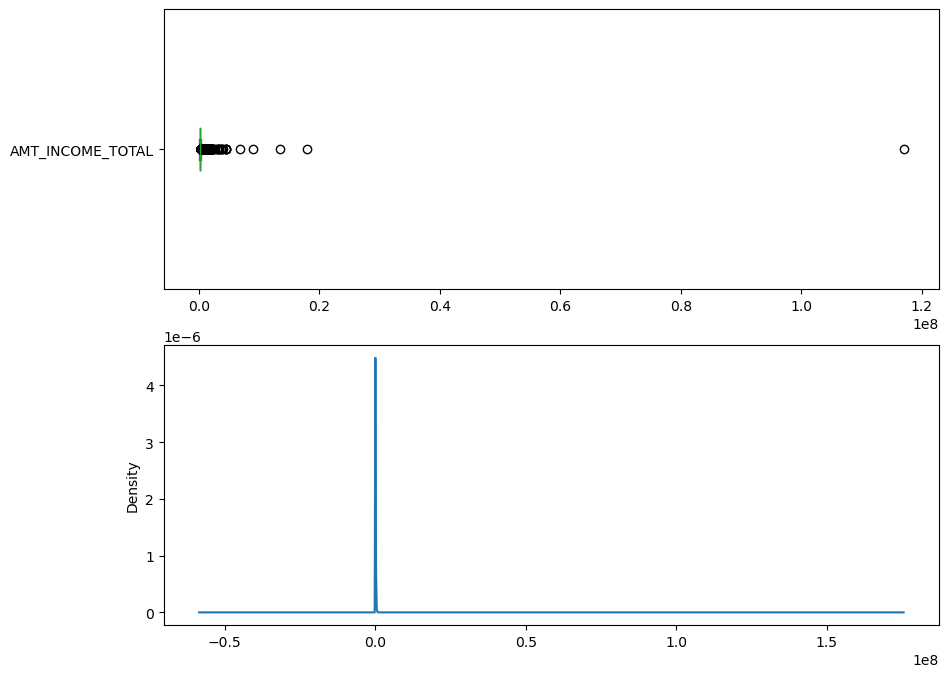

*********************** AMT_CREDIT ***********************

lower outlier: 0 ****** upper outlier: 6562



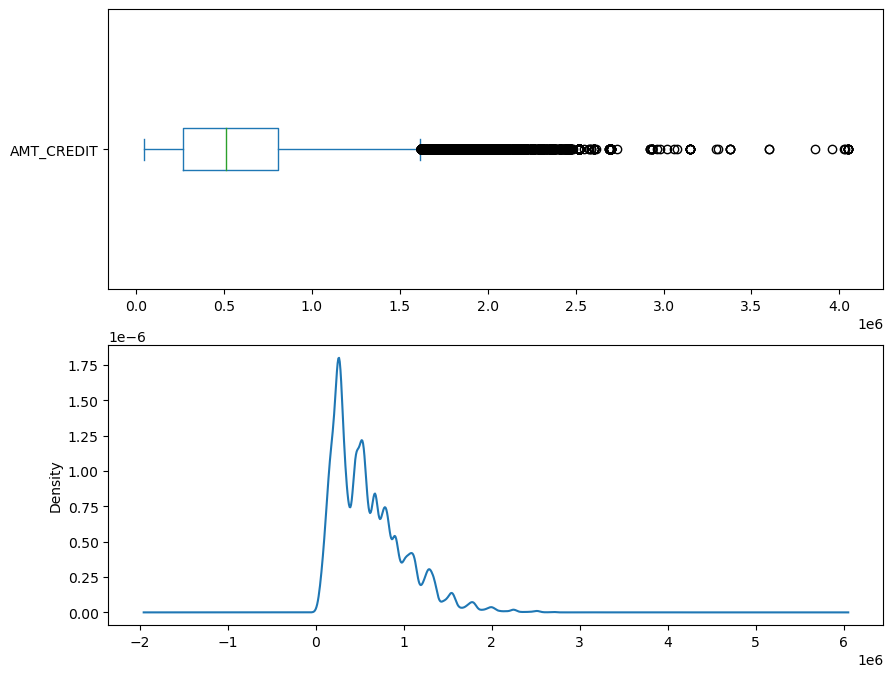

*********************** AMT_ANNUITY ***********************

lower outlier: 0 ****** upper outlier: 7504



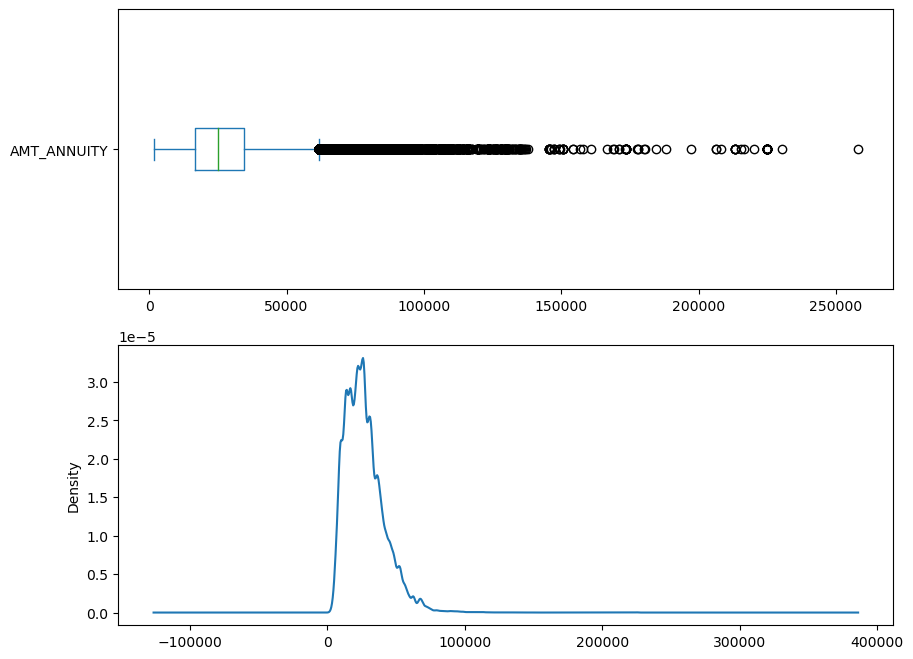

*********************** AMT_GOODS_PRICE ***********************

lower outlier: 0 ****** upper outlier: 14728



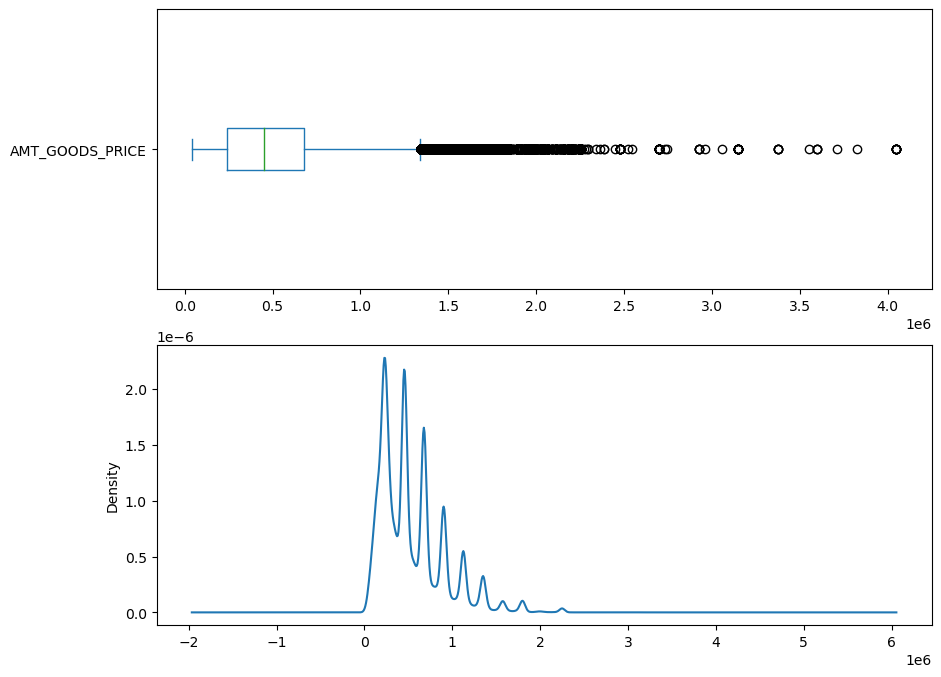

*********************** REGION_POPULATION_RELATIVE ***********************

lower outlier: 0 ****** upper outlier: 8412



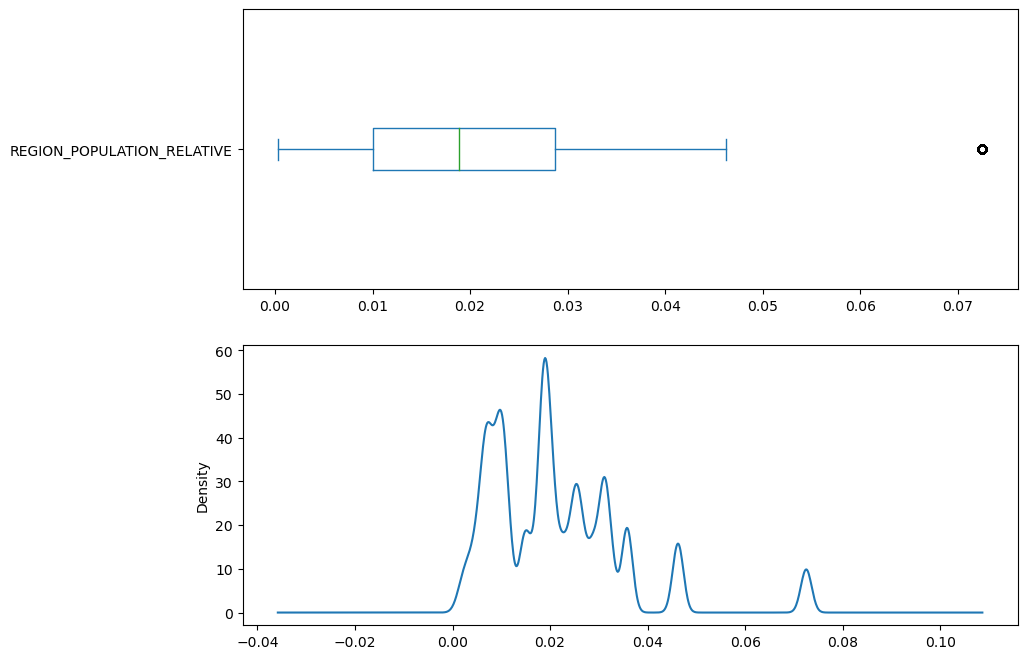

*********************** DAYS_REGISTRATION ***********************

lower outlier: 659 ****** upper outlier: 0



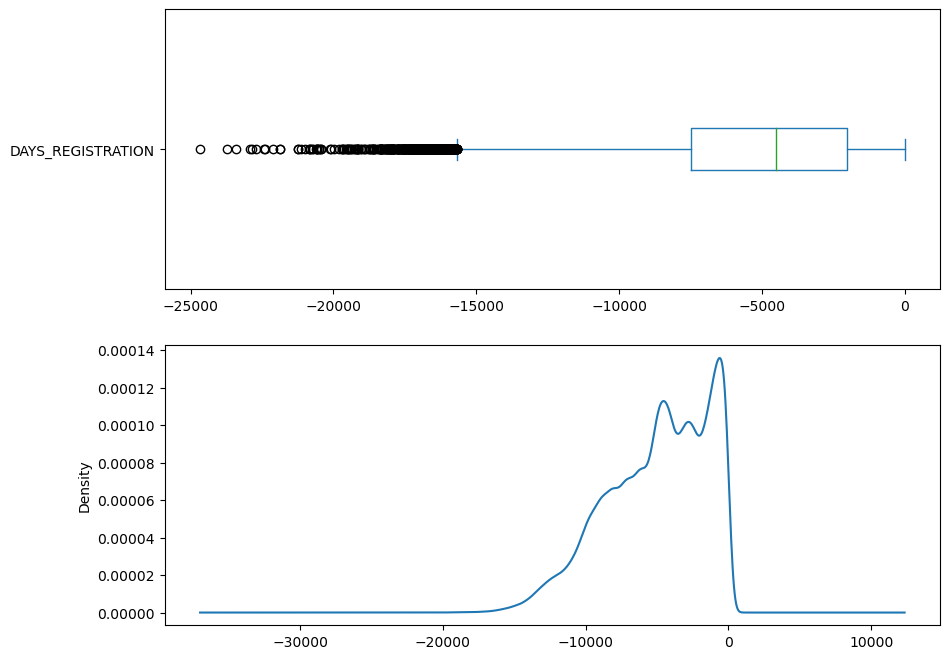

*********************** CNT_FAM_MEMBERS ***********************

lower outlier: 0 ****** upper outlier: 4007



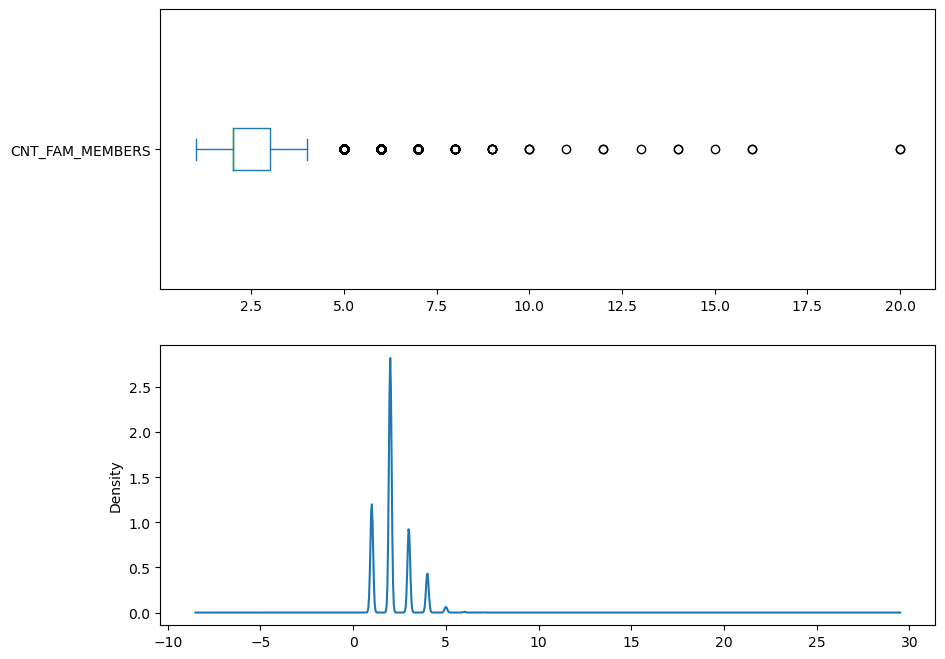

*********************** EXT_SOURCE_2 ***********************

lower outlier: 0 ****** upper outlier: 0



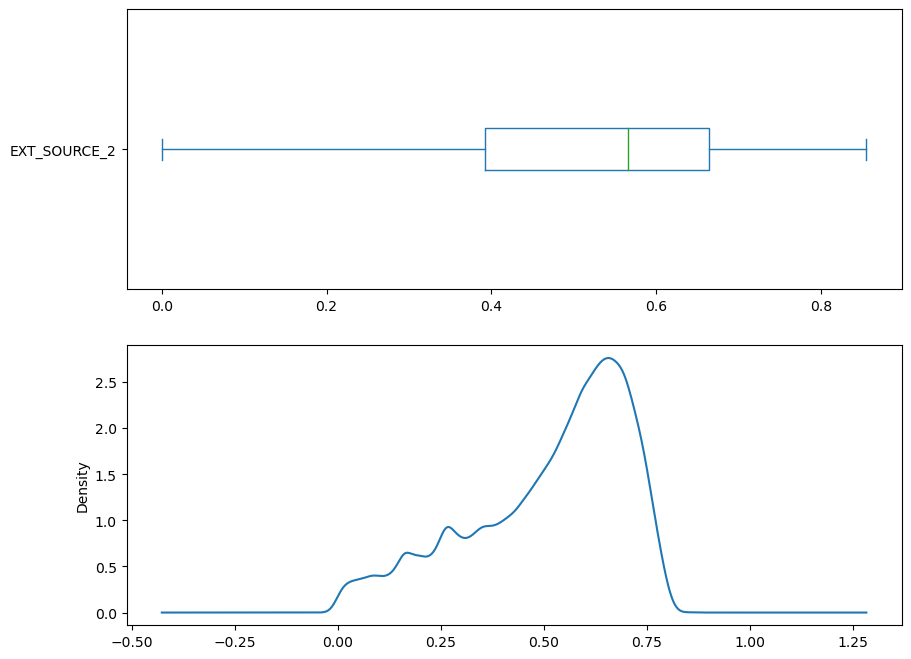

*********************** EXT_SOURCE_3 ***********************

lower outlier: 0 ****** upper outlier: 0



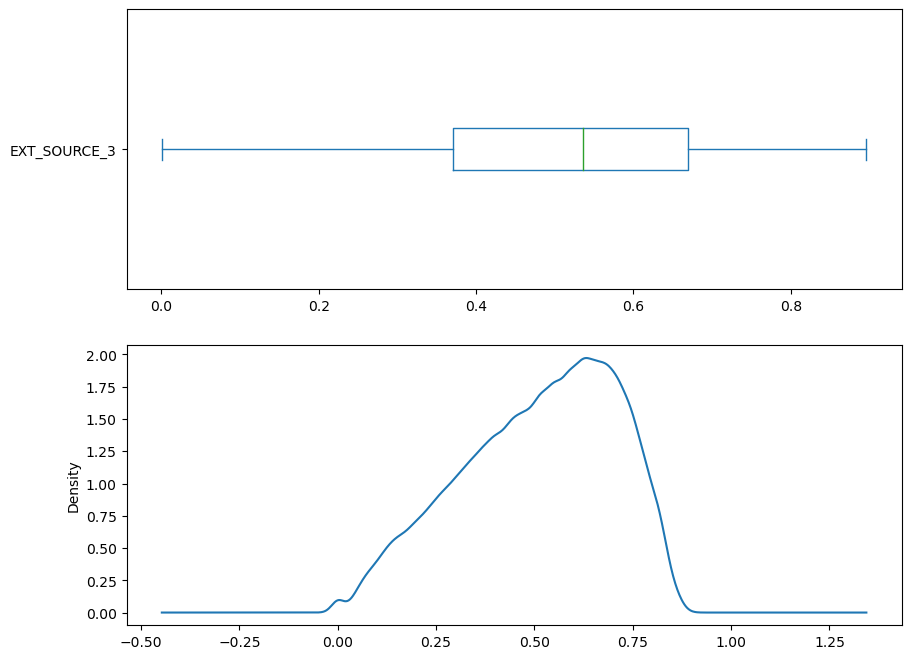

*********************** OBS_30_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 19971



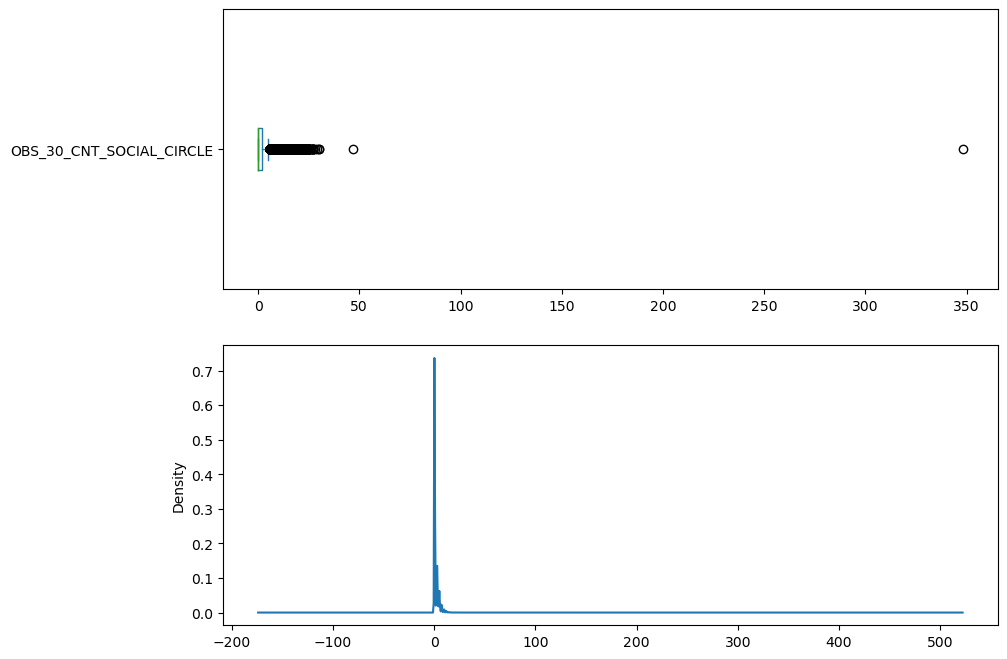

*********************** DEF_30_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 35166



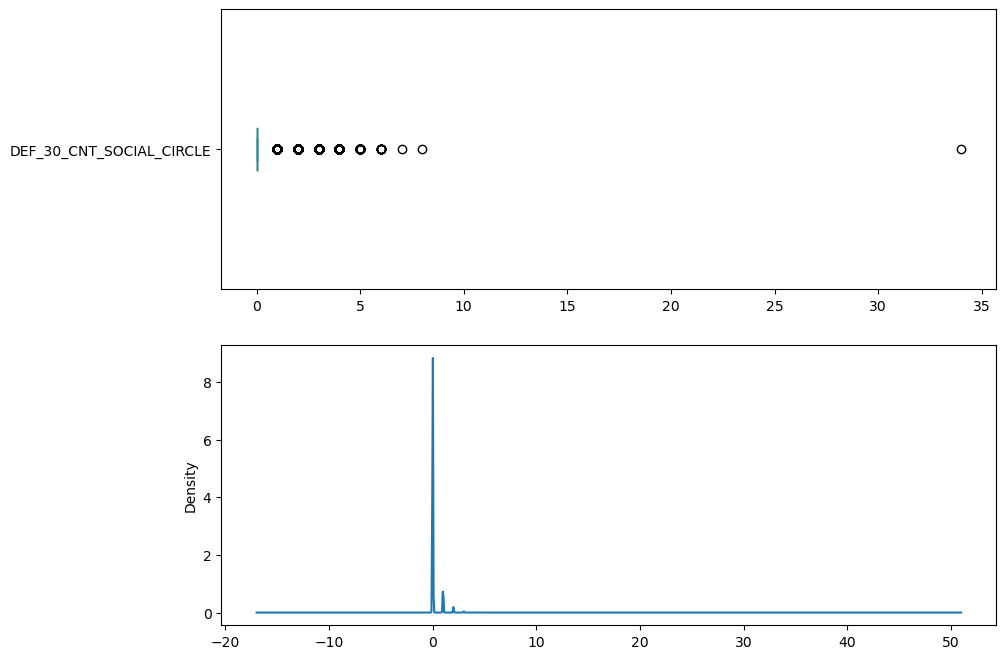

*********************** OBS_60_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 19564



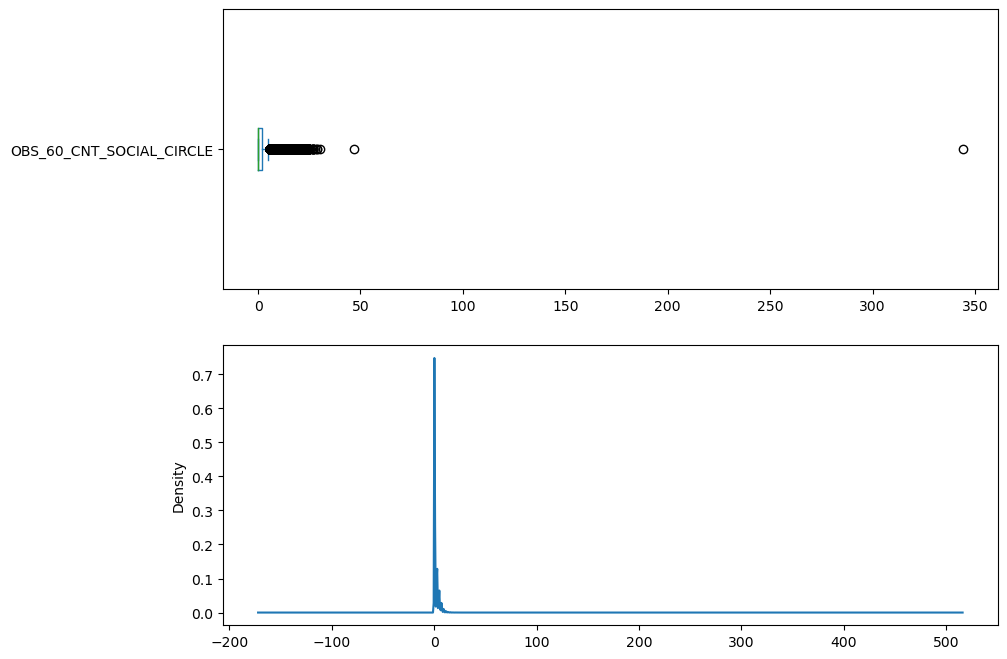

*********************** DEF_60_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 25769



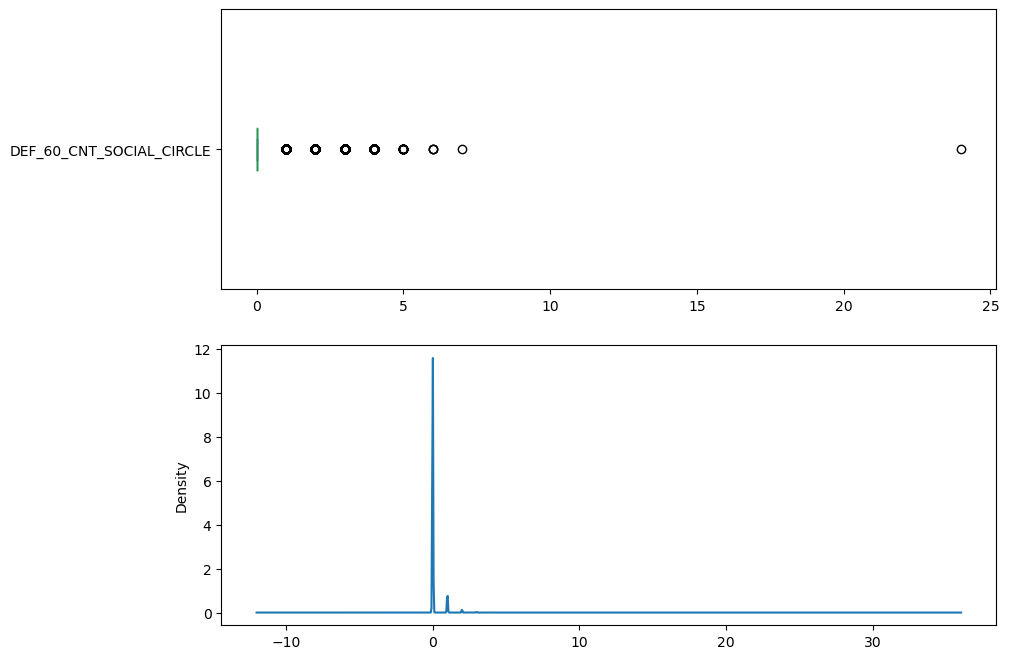

*********************** DAYS_LAST_PHONE_CHANGE ***********************

lower outlier: 435 ****** upper outlier: 0



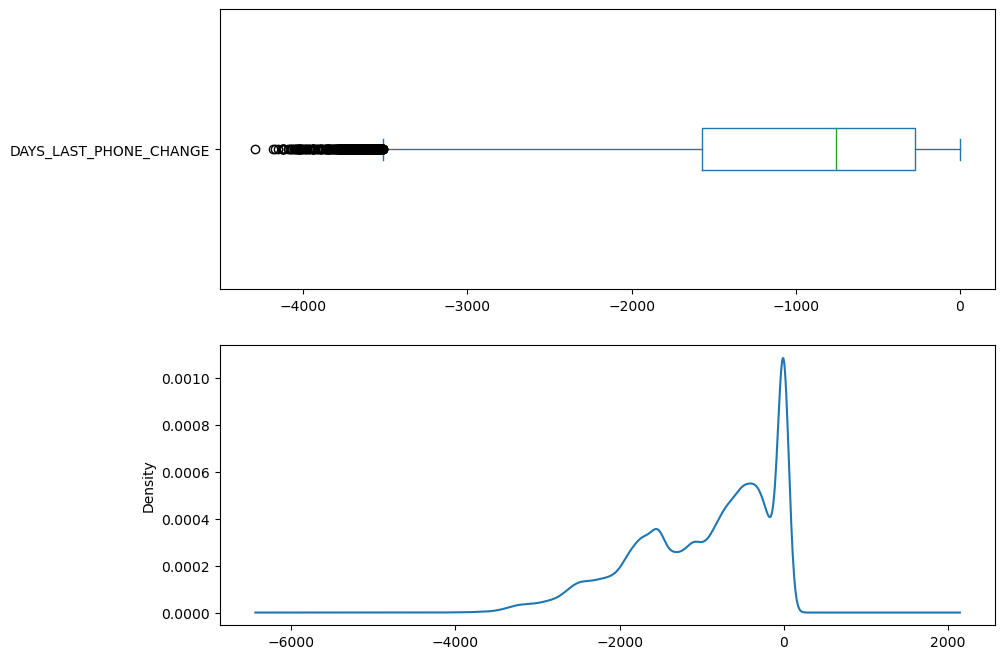

*********************** AMT_REQ_CREDIT_BUREAU_HOUR ***********************

lower outlier: 0 ****** upper outlier: 1626



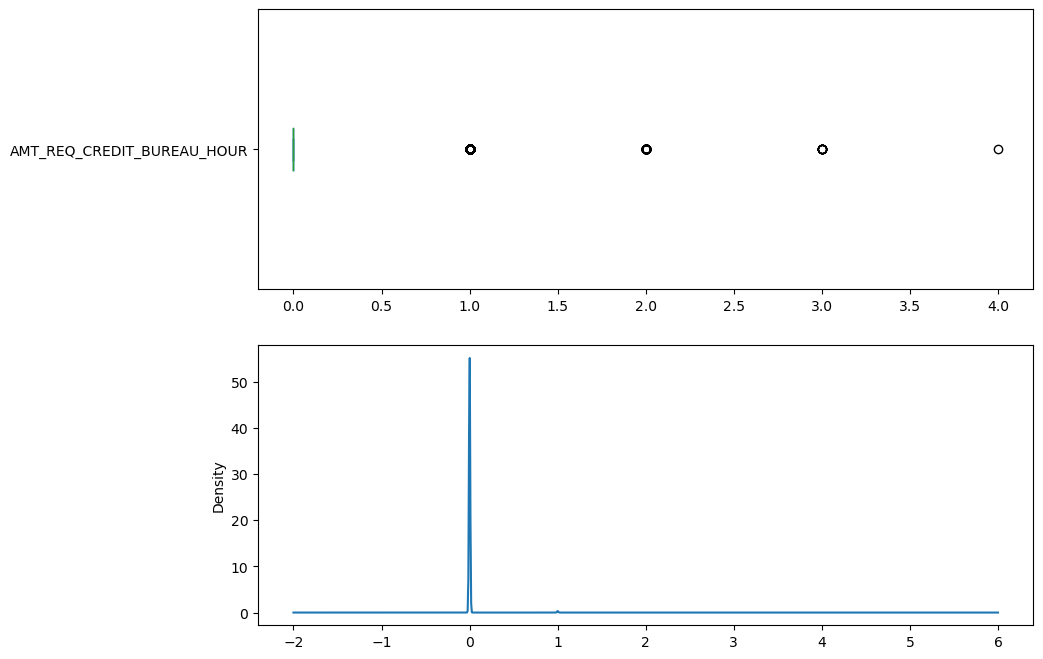

*********************** AMT_REQ_CREDIT_BUREAU_DAY ***********************

lower outlier: 0 ****** upper outlier: 1489



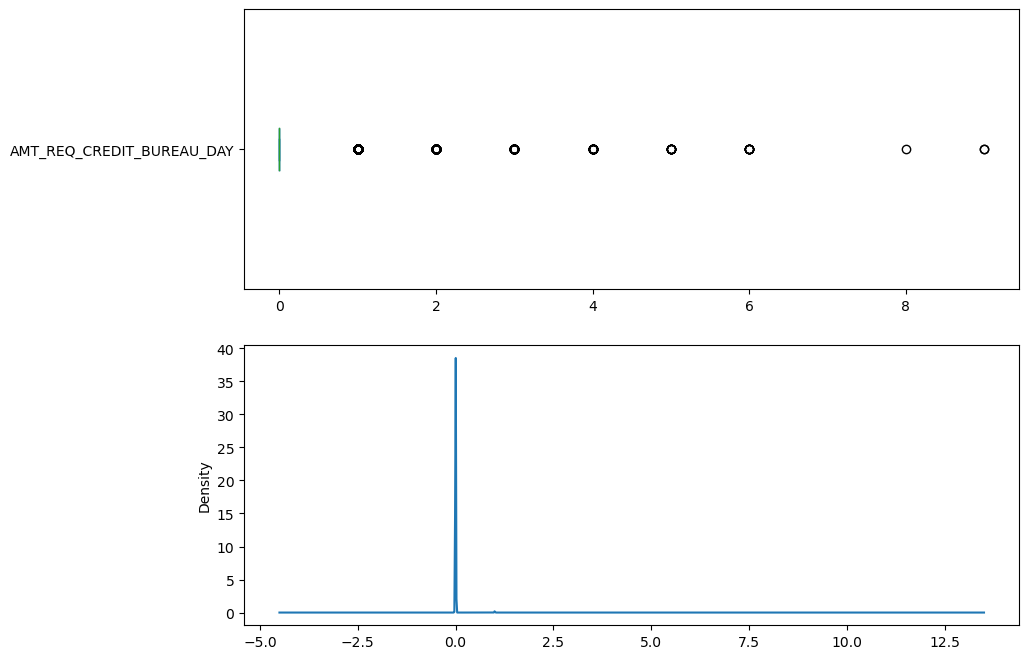

*********************** AMT_REQ_CREDIT_BUREAU_WEEK ***********************

lower outlier: 0 ****** upper outlier: 8536



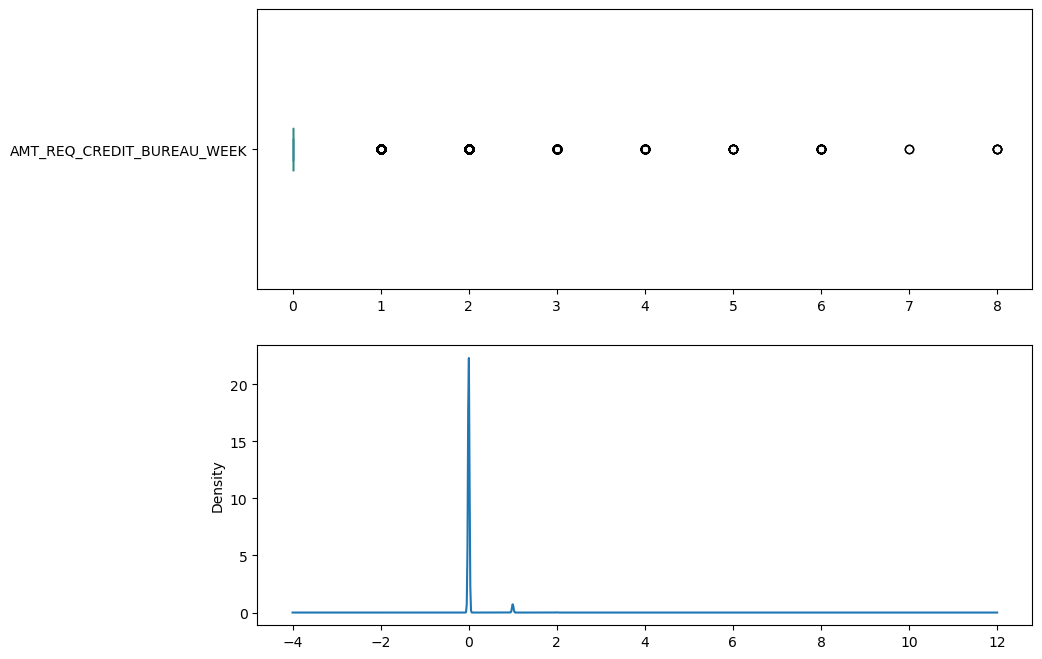

*********************** AMT_REQ_CREDIT_BUREAU_MON ***********************

lower outlier: 0 ****** upper outlier: 43759



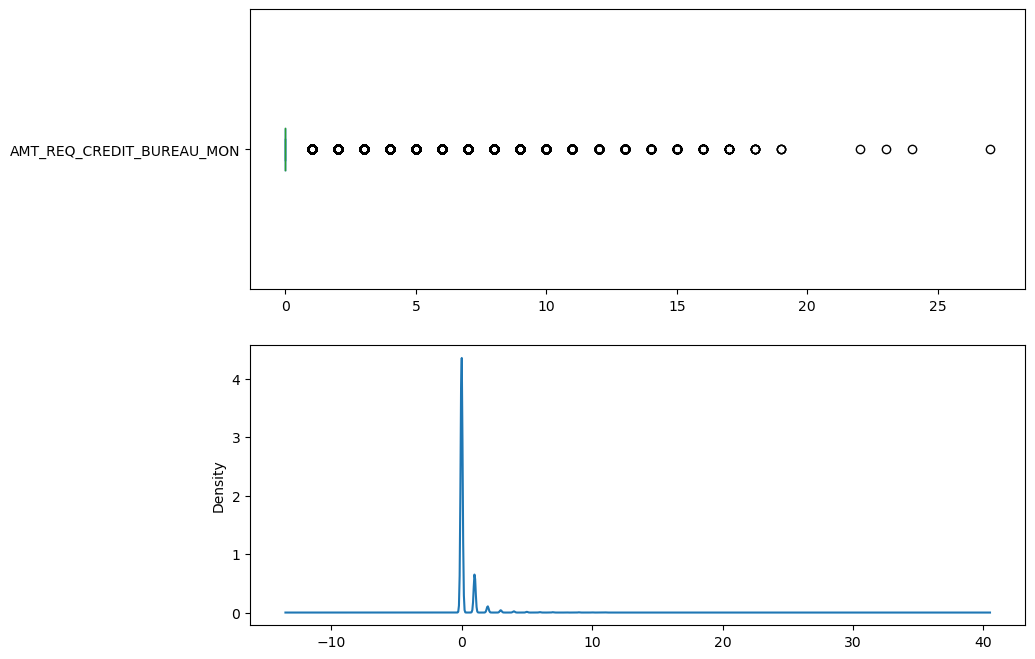

*********************** AMT_REQ_CREDIT_BUREAU_QRT ***********************

lower outlier: 0 ****** upper outlier: 50575



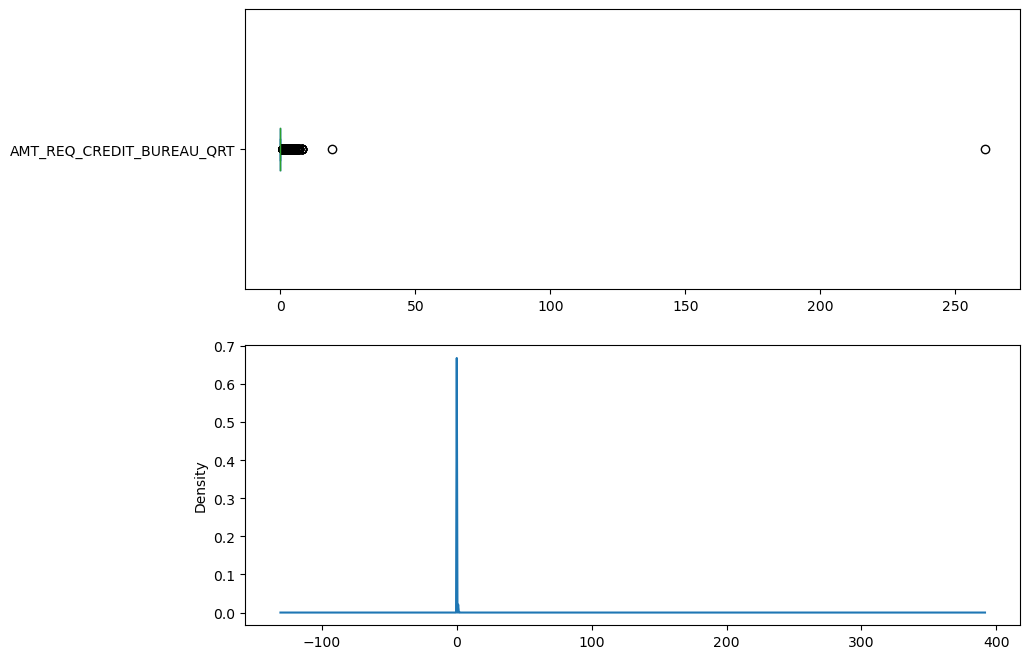

*********************** AMT_REQ_CREDIT_BUREAU_YEAR ***********************

lower outlier: 0 ****** upper outlier: 3364



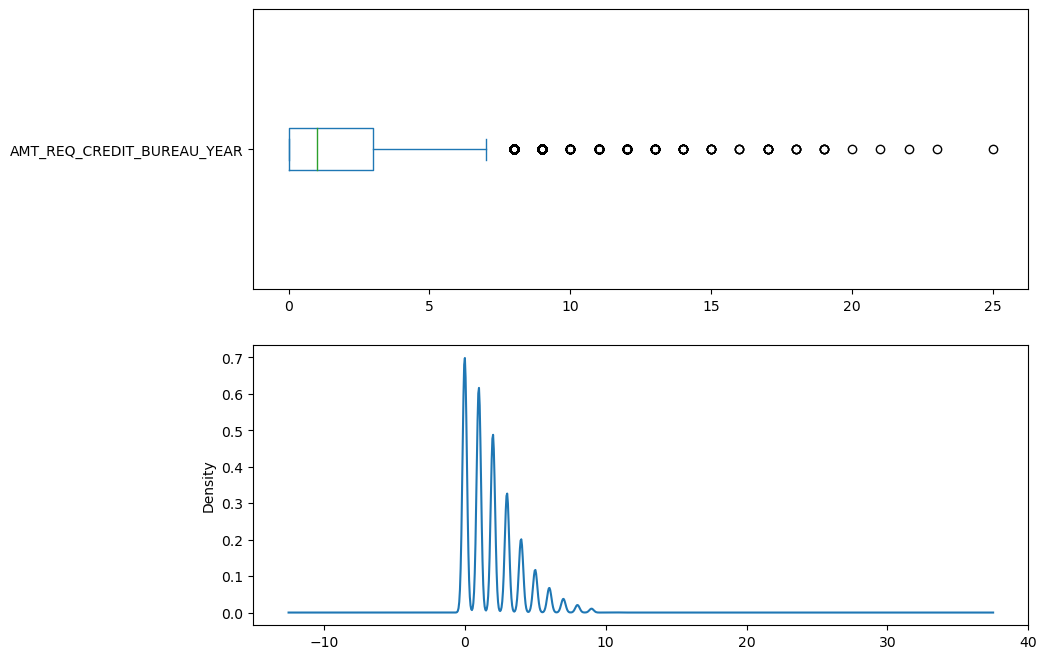

In [25]:
# Affichage des valeurs outliers "inf" & "sup" et boxplot & density graph pour les variables quantitatives continue 
for i in range(len(continuous_col)):
    preprocess(continuous[continuous_col], continuous_col[i])

In [26]:
# Variable quantitatives continue avec des valeurs Nan
continuous_is_null = continuous.isnull().sum() != 0
final_continuous_feature = continuous.columns[continuous_is_null].tolist()
print("In train: \n",final_continuous_feature)

print("****************************************")
continuous_is_null_test = continuous_test.isnull().sum() != 0
final_continuous_feature_test = continuous_test.columns[continuous_is_null_test].tolist()
print("In test: \n",final_continuous_feature_test)

In train: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
****************************************
In test: 
 ['AMT_ANNUITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [27]:
# Remplacement des valeurs Nan par la moyenne pour chaque colonne
print("In train:\n")
for i in range(len(final_continuous_feature)):
    replace_mean(continuous, final_continuous_feature[i])

print("************************************")
print("In test:\n")
for i in range(len(final_continuous_feature_test)):
    replace_mean(continuous_test, final_continuous_feature_test[i])

In train:

NaN in AMT_ANNUITY raplaced with 27108.573909183444
NaN in AMT_GOODS_PRICE raplaced with 538396.2074288887
NaN in CNT_FAM_MEMBERS raplaced with 2.1526654504421012
NaN in EXT_SOURCE_2 raplaced with 0.5143926741308488
NaN in EXT_SOURCE_3 raplaced with 0.5108529061805426
NaN in OBS_30_CNT_SOCIAL_CIRCLE raplaced with 1.4222454239942892
NaN in DEF_30_CNT_SOCIAL_CIRCLE raplaced with 0.1434206662533827
NaN in OBS_60_CNT_SOCIAL_CIRCLE raplaced with 1.4052921791902133
NaN in DEF_60_CNT_SOCIAL_CIRCLE raplaced with 0.10004894123788487
NaN in DAYS_LAST_PHONE_CHANGE raplaced with -962.8587883320869
NaN in AMT_REQ_CREDIT_BUREAU_HOUR raplaced with 0.0064024481939340665
NaN in AMT_REQ_CREDIT_BUREAU_DAY raplaced with 0.007000210532644792
NaN in AMT_REQ_CREDIT_BUREAU_WEEK raplaced with 0.03436193569730462
NaN in AMT_REQ_CREDIT_BUREAU_MON raplaced with 0.26739526000773584
NaN in AMT_REQ_CREDIT_BUREAU_QRT raplaced with 0.2654741495984415
NaN in AMT_REQ_CREDIT_BUREAU_YEAR raplaced with 1.8999744

In [28]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0


In [29]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0


In [30]:
numeric[continuous_col] = continuous[continuous_col]

# ----------------------------------------------
numeric_test[continuous_col] = continuous_test[continuous_col]

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Outlier</h3></center>
</div>

In [31]:
col_names = numeric.columns

# ------------------------------------
col_names_test = numeric_test.columns

In [32]:
# Affichage des colonnes avec le nombre d'outliers
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(outlier_detect(numeric,col_names[i]).shape[0])))
    
print("\n\n***************************************\n")
print("In test:\n")
for i in range(len(col_names_test)):
    print("{}: {}".format(col_names_test[i],(outlier_detect(numeric_test,col_names_test[i]).shape[0])))

In train:

SK_ID_CURR: 0
TARGET: 24825
CNT_CHILDREN: 4272
AMT_INCOME_TOTAL: 14035
AMT_CREDIT: 6562
AMT_ANNUITY: 7504
AMT_GOODS_PRICE: 14728
REGION_POPULATION_RELATIVE: 8412
DAYS_BIRTH: 0
DAYS_EMPLOYED: 72217
DAYS_REGISTRATION: 659
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 55386
FLAG_WORK_PHONE: 61308
FLAG_CONT_MOBILE: 574
FLAG_PHONE: 0
FLAG_EMAIL: 17442
CNT_FAM_MEMBERS: 4007
REGION_RATING_CLIENT: 80527
REGION_RATING_CLIENT_W_CITY: 78027
HOUR_APPR_PROCESS_START: 2257
REG_REGION_NOT_LIVE_REGION: 4657
REG_REGION_NOT_WORK_REGION: 15612
LIVE_REGION_NOT_WORK_REGION: 12503
REG_CITY_NOT_LIVE_CITY: 24039
REG_CITY_NOT_WORK_CITY: 70867
LIVE_CITY_NOT_WORK_CITY: 55215
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 19971
DEF_30_CNT_SOCIAL_CIRCLE: 36187
OBS_60_CNT_SOCIAL_CIRCLE: 19564
DEF_60_CNT_SOCIAL_CIRCLE: 26790
DAYS_LAST_PHONE_CHANGE: 435
FLAG_DOCUMENT_2: 13
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 25
FLAG_DOCUMENT_5: 4648
FLAG_DOCUMENT_6: 27078
FLAG_DOCUMENT_7: 59
FLAG_DOCUMENT_8: 

In [33]:
# Enrengistrement des colonnes avec outliers
outlier = []
for i in range(len(final_numeric_feature)):
    if outlier_detect(numeric[final_numeric_feature],final_numeric_feature[i]).shape[0] !=0:
        outlier.append(final_numeric_feature[i])

outlier_test = []
for i in range(len(final_numeric_feature_test)):
    if outlier_detect(numeric_test[final_numeric_feature_test],final_numeric_feature_test[i]).shape[0] !=0:
        outlier_test.append(final_numeric_feature_test[i])

In [34]:
# without TARGET field
col_names = outlier_test

In [35]:
# Affichage du nombre d'outliers "sup"
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 4272
AMT_INCOME_TOTAL: 14035
AMT_CREDIT: 6562
AMT_ANNUITY: 7504
AMT_GOODS_PRICE: 14728
REGION_POPULATION_RELATIVE: 8412
DAYS_EMPLOYED: 55374
DAYS_REGISTRATION: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 61308
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 17442
CNT_FAM_MEMBERS: 4007
REGION_RATING_CLIENT: 48330
REGION_RATING_CLIENT_W_CITY: 43860
HOUR_APPR_PROCESS_START: 596
REG_REGION_NOT_LIVE_REGION: 4657
REG_REGION_NOT_WORK_REGION: 15612
LIVE_REGION_NOT_WORK_REGION: 12503
REG_CITY_NOT_LIVE_CITY: 24039
REG_CITY_NOT_WORK_CITY: 70867
LIVE_CITY_NOT_WORK_CITY: 55215
OBS_30_CNT_SOCIAL_CIRCLE: 19971
DEF_30_CNT_SOCIAL_CIRCLE: 36187
OBS_60_CNT_SOCIAL_CIRCLE: 19564
DEF_60_CNT_SOCIAL_CIRCLE: 26790
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_4: 25
FLAG_DOCUMENT_5: 4648
FLAG_DOCUMENT_6: 27078
FLAG_DOCUMENT_7: 59
FLAG_DOCUMENT_8: 25024
FLAG_DOCUMENT_9: 1198
FLAG_DOCUMENT_11: 1203
FLAG_DOCUMENT_18: 2500
AMT_REQ_CREDIT_BUREAU_HOUR: 43145
AMT_REQ_CREDIT_BUREAU_DAY: 43008
AMT_REQ_CREDIT_B

In [36]:
# Remplacement des outliers "sup"
for i in range(len(col_names)):
    replace_upper(numeric, col_names[i])   
    
#------------------------------------------------------
for i in range(len(col_names)):
    replace_upper(numeric_test, col_names[i])   

In [37]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_18: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_DAY: 0
AMT_REQ_CREDIT_BUREAU_WEEK: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0


**********

In [38]:
# Affichage du nombre d'outliers "inf"
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 16843
DAYS_REGISTRATION: 659
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 55386
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 574
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 32197
REGION_RATING_CLIENT_W_CITY: 34167
HOUR_APPR_PROCESS_START: 1661
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 435
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_18: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_DAY: 0
AMT_REQ_CREDIT_BUREAU_WEEK: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BU

In [39]:
# Remplacement des outliers "inf"
for i in range(len(col_names)):
    replace_lower(numeric, col_names[i])
    
# #--------------------------------------------------
for i in range(len(col_names)):
    replace_lower(numeric_test, col_names[i])

In [40]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_18: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_DAY: 0
AMT_REQ_CREDIT_BUREAU_WEEK: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0


**********

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
2. Categorical field</h3>
</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Missing Data</h3></center>
</div>

In [41]:
# Variables qualitatives
categorical_feature = train_new.dtypes==object
final_categorical_feature = train_new.columns[categorical_feature].tolist()

#----------------------------------------------------
categorical_feature_test = test_new.dtypes==object
final_categorical_feature_test = test_new.columns[categorical_feature_test].tolist()

In [42]:
categorical = train_new[final_categorical_feature]

#---------------------------------------------
categorical_test = test_new[final_categorical_feature_test]
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [43]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,96391
NAME_TYPE_SUITE,1292
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [44]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,15605
NAME_TYPE_SUITE,911
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [45]:
col_names_cat = categorical.columns

******************** NAME_CONTRACT_TYPE ********************



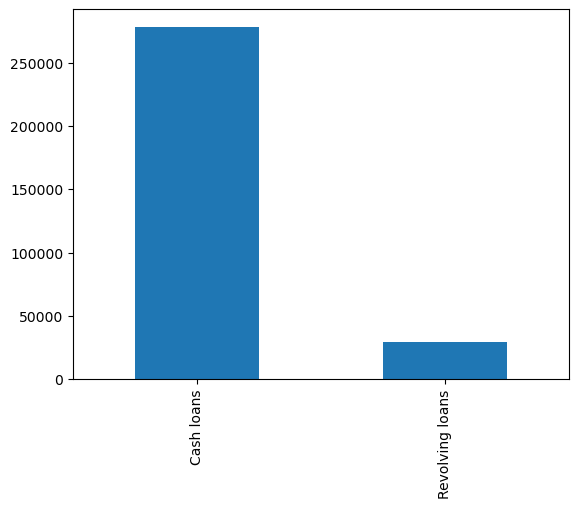

******************** CODE_GENDER ********************



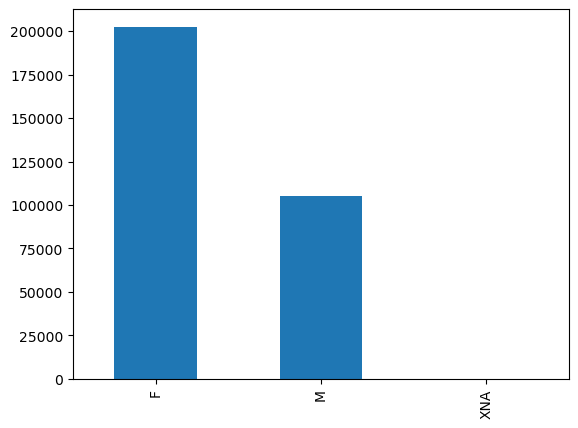

******************** FLAG_OWN_CAR ********************



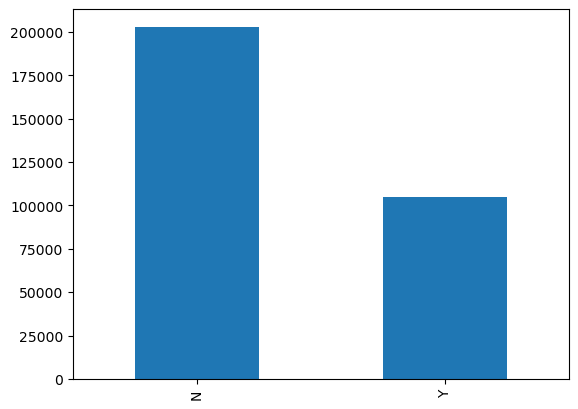

******************** FLAG_OWN_REALTY ********************



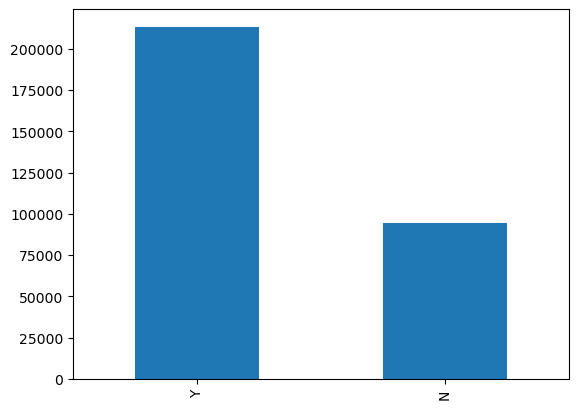

******************** NAME_TYPE_SUITE ********************



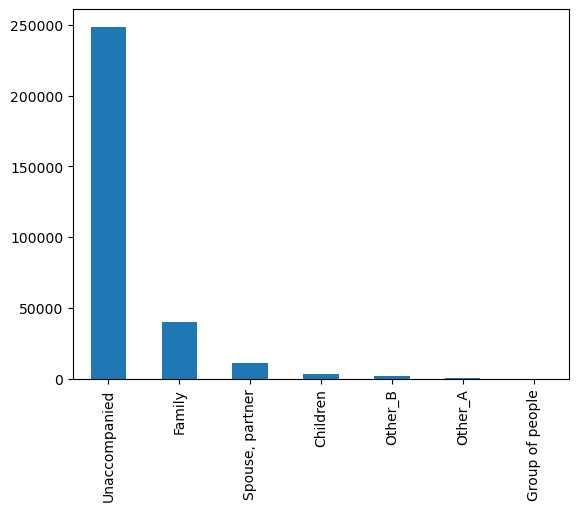

******************** NAME_INCOME_TYPE ********************



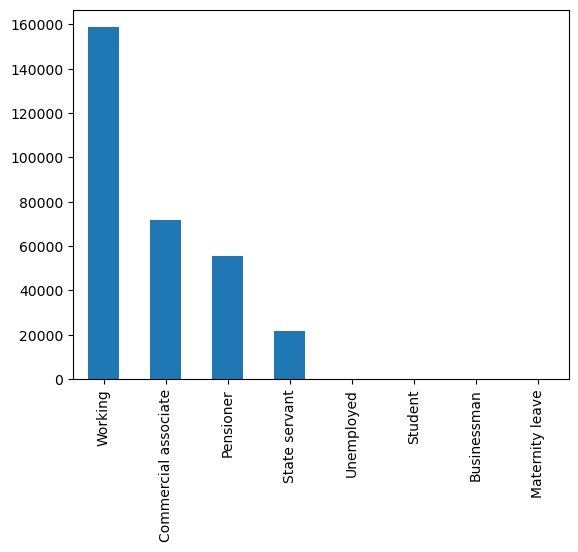

******************** NAME_EDUCATION_TYPE ********************



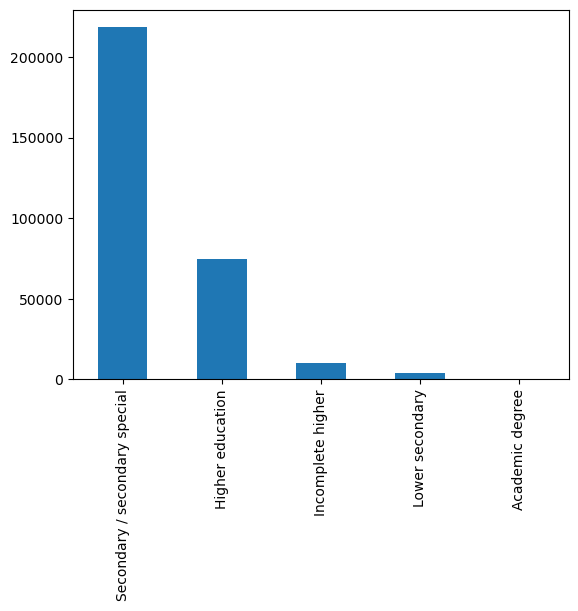

******************** NAME_FAMILY_STATUS ********************



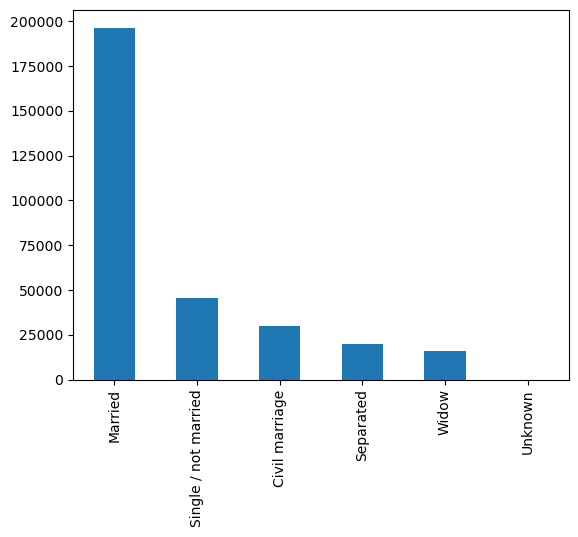

******************** NAME_HOUSING_TYPE ********************



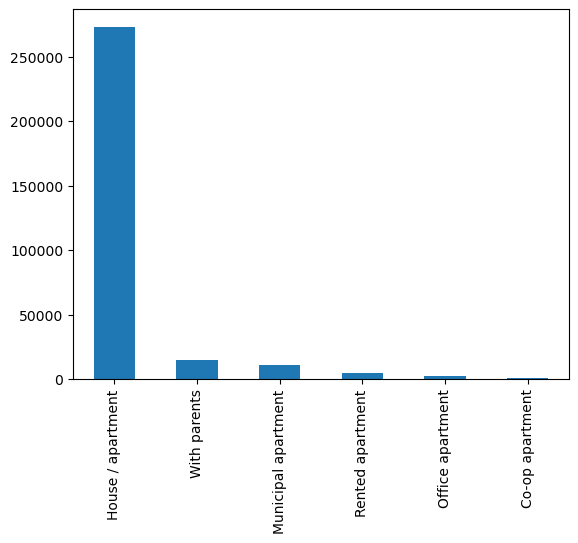

******************** OCCUPATION_TYPE ********************



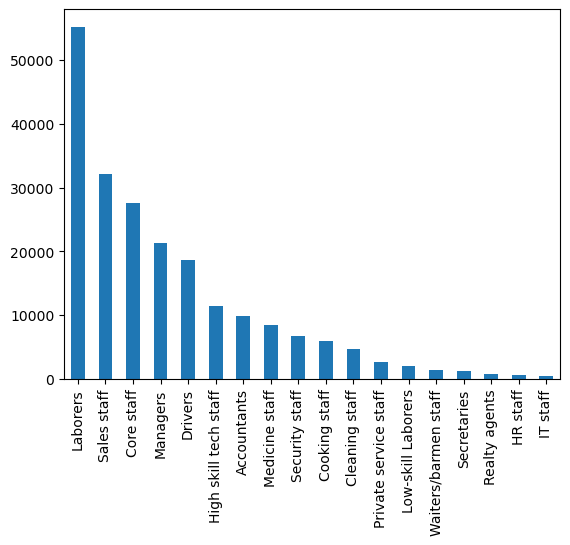

******************** WEEKDAY_APPR_PROCESS_START ********************



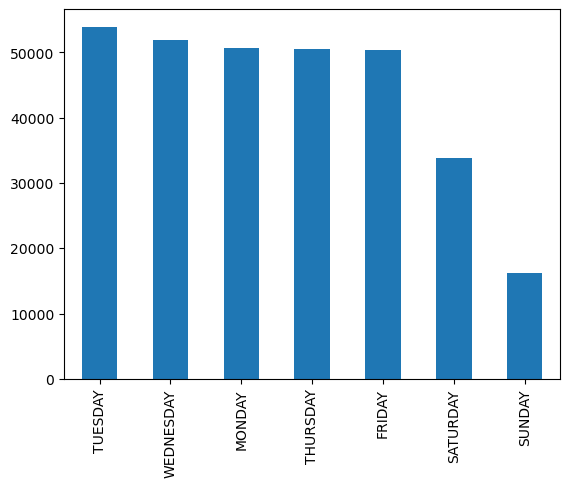

******************** ORGANIZATION_TYPE ********************



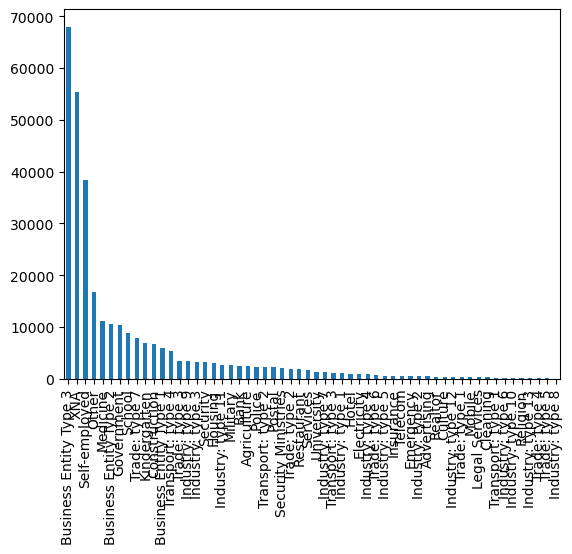

In [46]:
for i in range(len(col_names_cat)):
    preprocess_cat(categorical, col_names_cat[i])

In [47]:
# Affichage des occurances de la variables "ORGANIZATION TYPE" variable avec le plus de valeurs différentes
print("unique number is = {}\nunique values are: \n{} ".format(len(train_new['ORGANIZATION_TYPE'].unique()), train_new['ORGANIZATION_TYPE'].unique()))

unique number is = 58
unique values are: 
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6'] 


In [48]:
# Remplacement des valeurs Nan par la modalité la plus présente par variables
print("In train:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical, col_names_cat[i])

print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical_test, col_names_cat[i])

In train:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in NAME_FAMILY_STATUS raplaced with Married
NaN in NAME_HOUSING_TYPE raplaced with House / apartment
NaN in OCCUPATION_TYPE raplaced with Laborers
NaN in WEEKDAY_APPR_PROCESS_START raplaced with TUESDAY
NaN in ORGANIZATION_TYPE raplaced with Business Entity Type 3


****************************************

In test:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in N

In [49]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [50]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [51]:
# Suppressions de la varibales "ORGANIZATION TYPE" ayant trop d'occurence pour le label encoder
categorical.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
# ---------------------------------------------
categorical_test.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [52]:
# Encodage des varibales qualitatives
le = LabelEncoder() 
categorical = categorical.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_test = categorical_test.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START
0,0,1,0,1,6,7,4,3,1,8,6
1,0,0,0,0,1,4,1,1,1,3,1
2,1,1,1,1,6,7,4,3,1,8,1
3,0,0,0,1,6,7,4,0,1,8,6
4,0,1,0,1,6,7,4,3,1,3,4


In [53]:
print("In train: ",categorical.shape)
print("In test: ",categorical_test.shape)

In train:  (307511, 11)
In test:  (48744, 11)


In [54]:
col_names_cat = categorical.columns
col_names = numeric_test.columns

In [55]:
train_new[col_names_cat] = categorical[col_names_cat]
train_new[col_names] = numeric[col_names]

# ----------------------------------------------------
test_new[col_names] = numeric_test[col_names]
test_new[col_names_cat] = categorical_test[col_names_cat]

In [56]:
train_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
test_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Duplicate Data</h3></center>
</div>

In [57]:
print("In train: ",train_new.loc[train.duplicated()].shape)
#--------------------------------------------------
print("In test: ",test_new.loc[test.duplicated()].shape)

In train:  (0, 72)
In test:  (0, 71)


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Data Correlation</h3></center>
</div>

In [58]:
def heatmap_correlation(df) :
    corr = df.corr()
    plt.figure(figsize=(30,30))
    sns.heatmap(corr, annot=True, linewidths=.2, cmap="YlGnBu")

In [59]:
# Variables par catégorie

var_flag = ['TARGET','FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'FLAG_PHONE']

var_amt = ['TARGET', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE']

var_info = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 
       'OBS_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'TARGET']

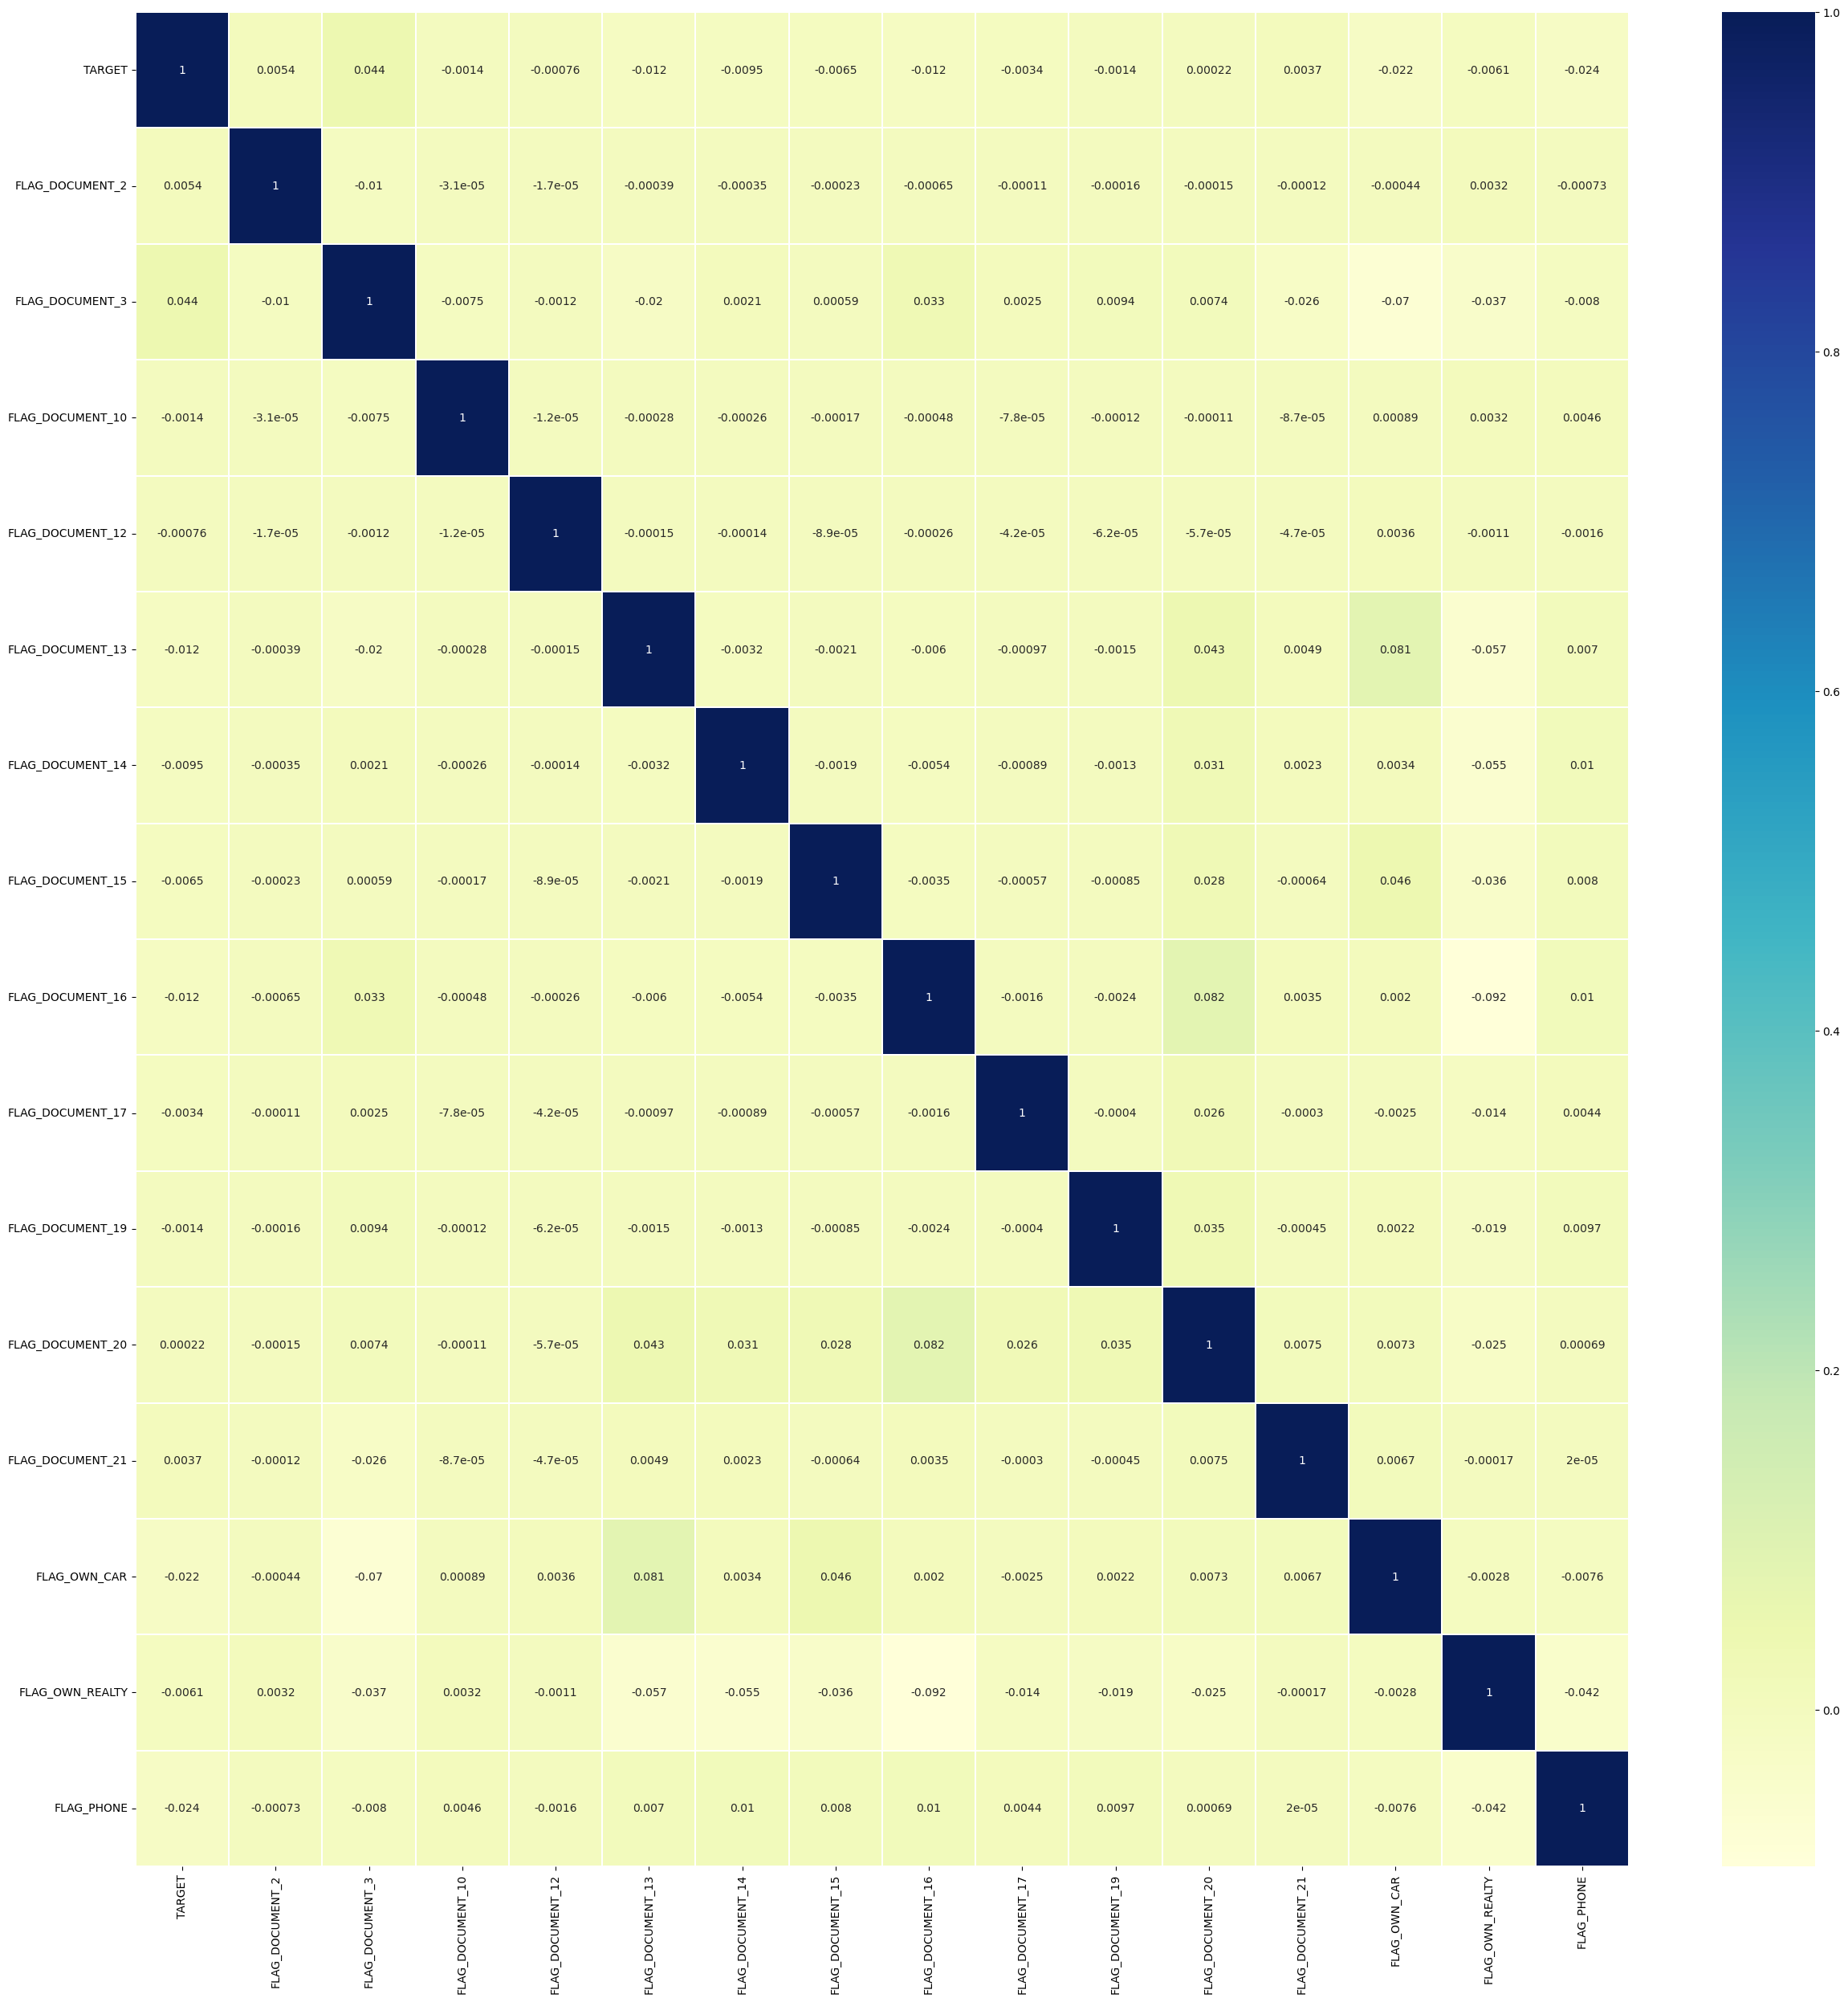

In [60]:
heatmap_correlation(train_new[var_flag])

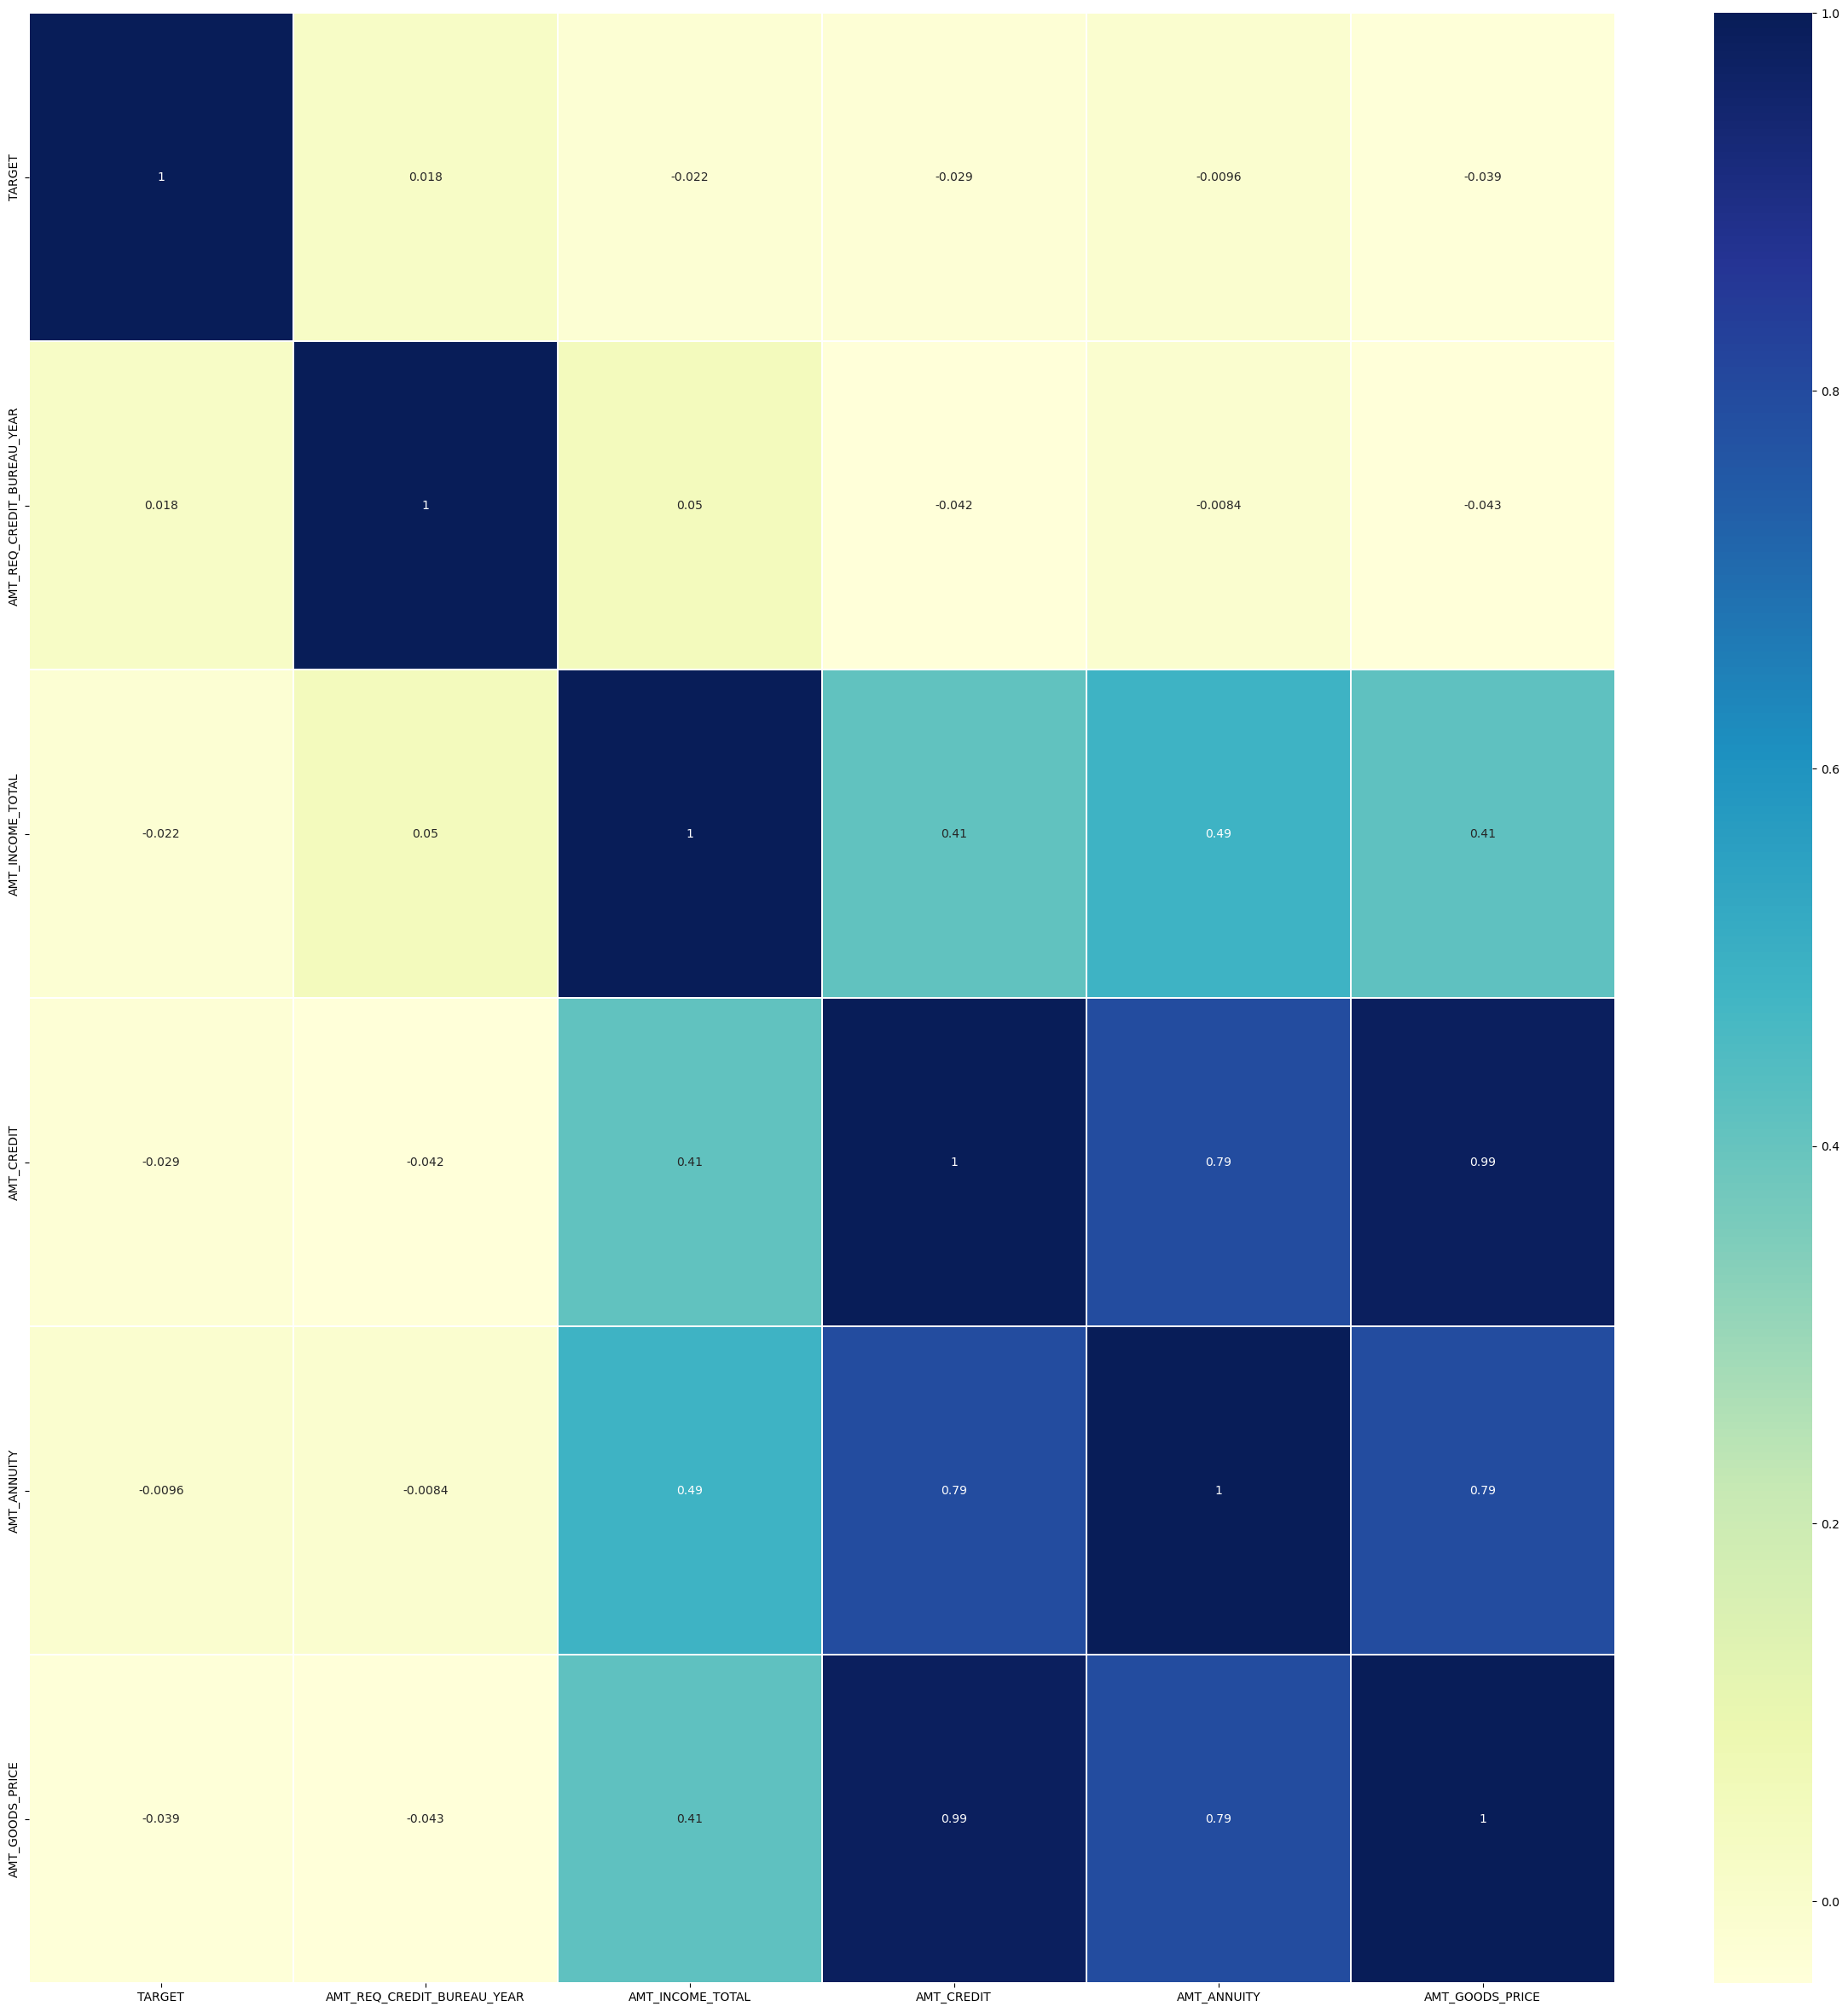

In [61]:
heatmap_correlation(train_new[var_amt])

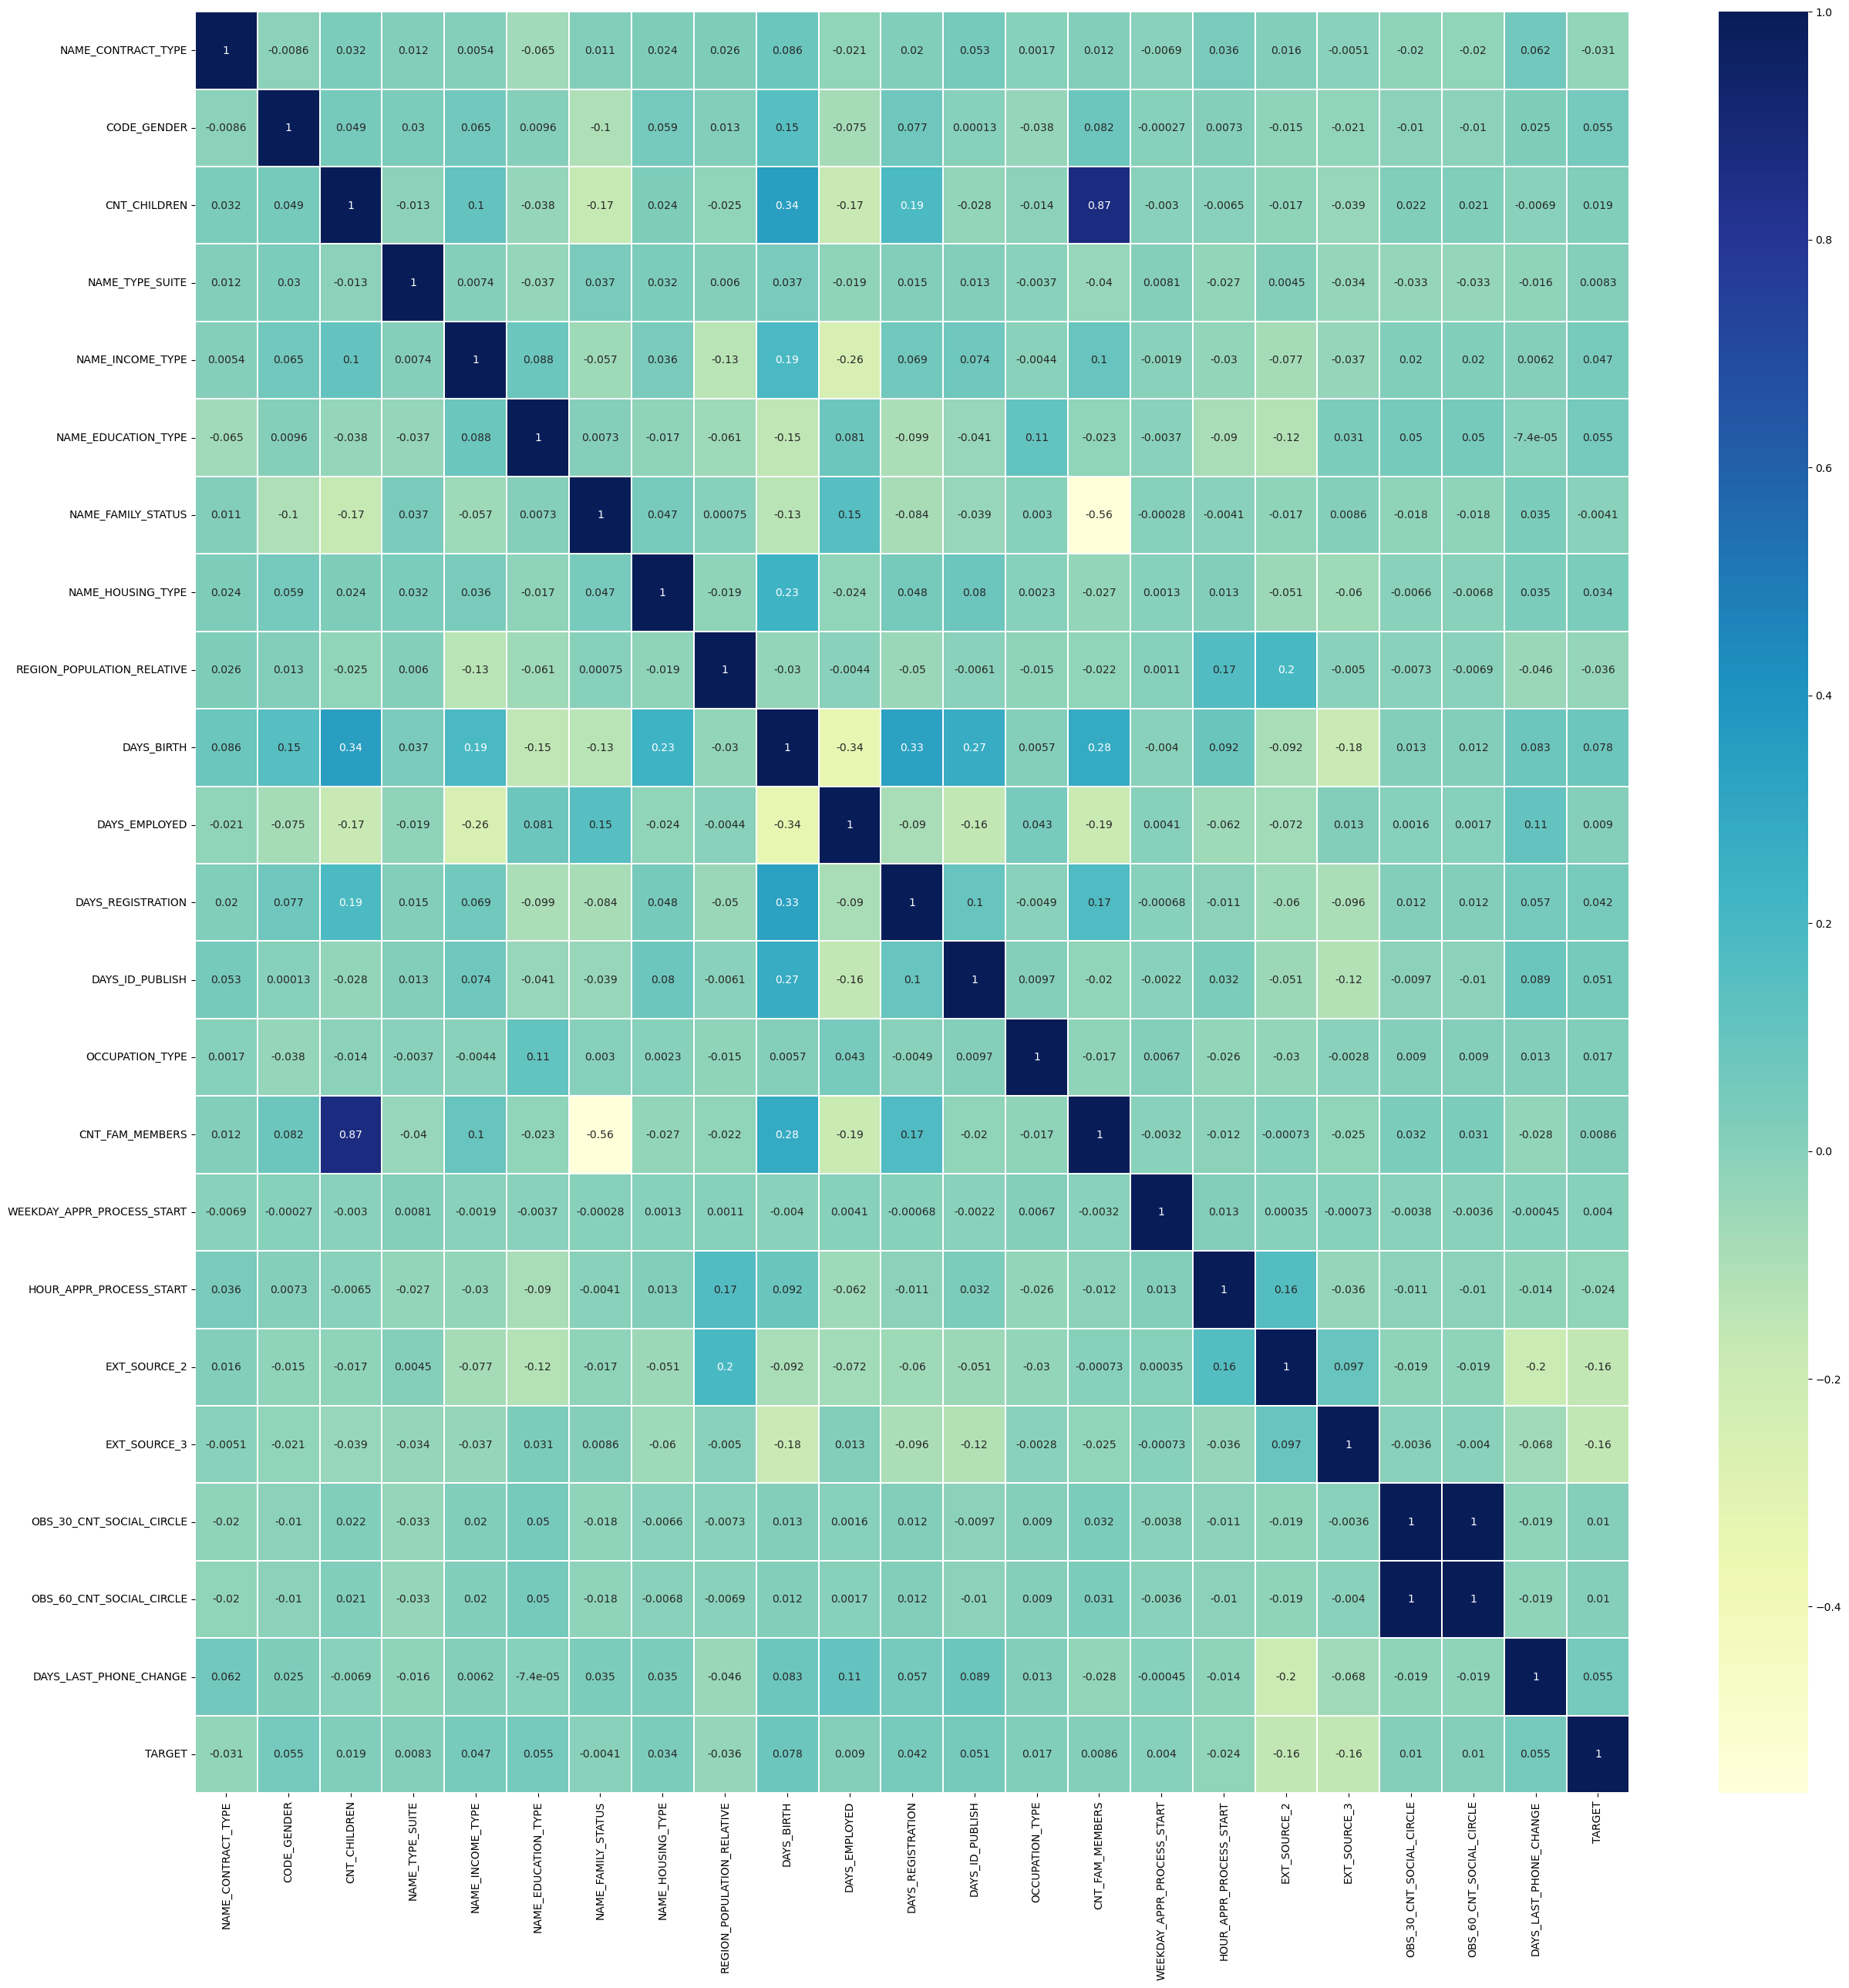

In [62]:
heatmap_correlation(train_new[var_info])

#### On remarque qu'aucune variable est corrélé à la variables cible target
#### Très peu de corrélation entre variables, on remarque tout de même une forte corrélation entre les variables AMT que l'on va tenter de modifier et entre CNT_FAM_MEMBERS et CNT_CHILDREN, ainsi que OBS_30_CNT_SOCIAL_CIRCLE et OBS_60_CNT_SOCIAL_CIRCLE

In [63]:
train_new[['DAYS_BIRTH','DAYS_EMPLOYED']].head()

,DAYS_BIRTH,DAYS_EMPLOYED
0,-9461,-637.0
1,-16765,-1188.0
2,-19046,-225.0
3,-19005,-3039.0
4,-19932,-3038.0


In [64]:
# Some simple new features (percentages)
train_new['DAYS_EMPLOYED_PERC'] = train_new['DAYS_EMPLOYED'] / train_new['DAYS_BIRTH']
train_new['INCOME_CREDIT_PERC'] = train_new['AMT_INCOME_TOTAL'] / train_new['AMT_CREDIT']
train_new['INCOME_PER_PERSON'] = train_new['AMT_INCOME_TOTAL'] / train_new['CNT_FAM_MEMBERS']
train_new['ANNUITY_INCOME_PERC'] = train_new['AMT_ANNUITY'] / train_new['AMT_INCOME_TOTAL']
train_new['PAYMENT_RATE'] = train_new['AMT_ANNUITY'] / train_new['AMT_CREDIT']
train_new['AGE'] = train_new['DAYS_BIRTH']/(-365)
train_new['WORK_AGE'] = train_new['DAYS_EMPLOYED']/(-365)

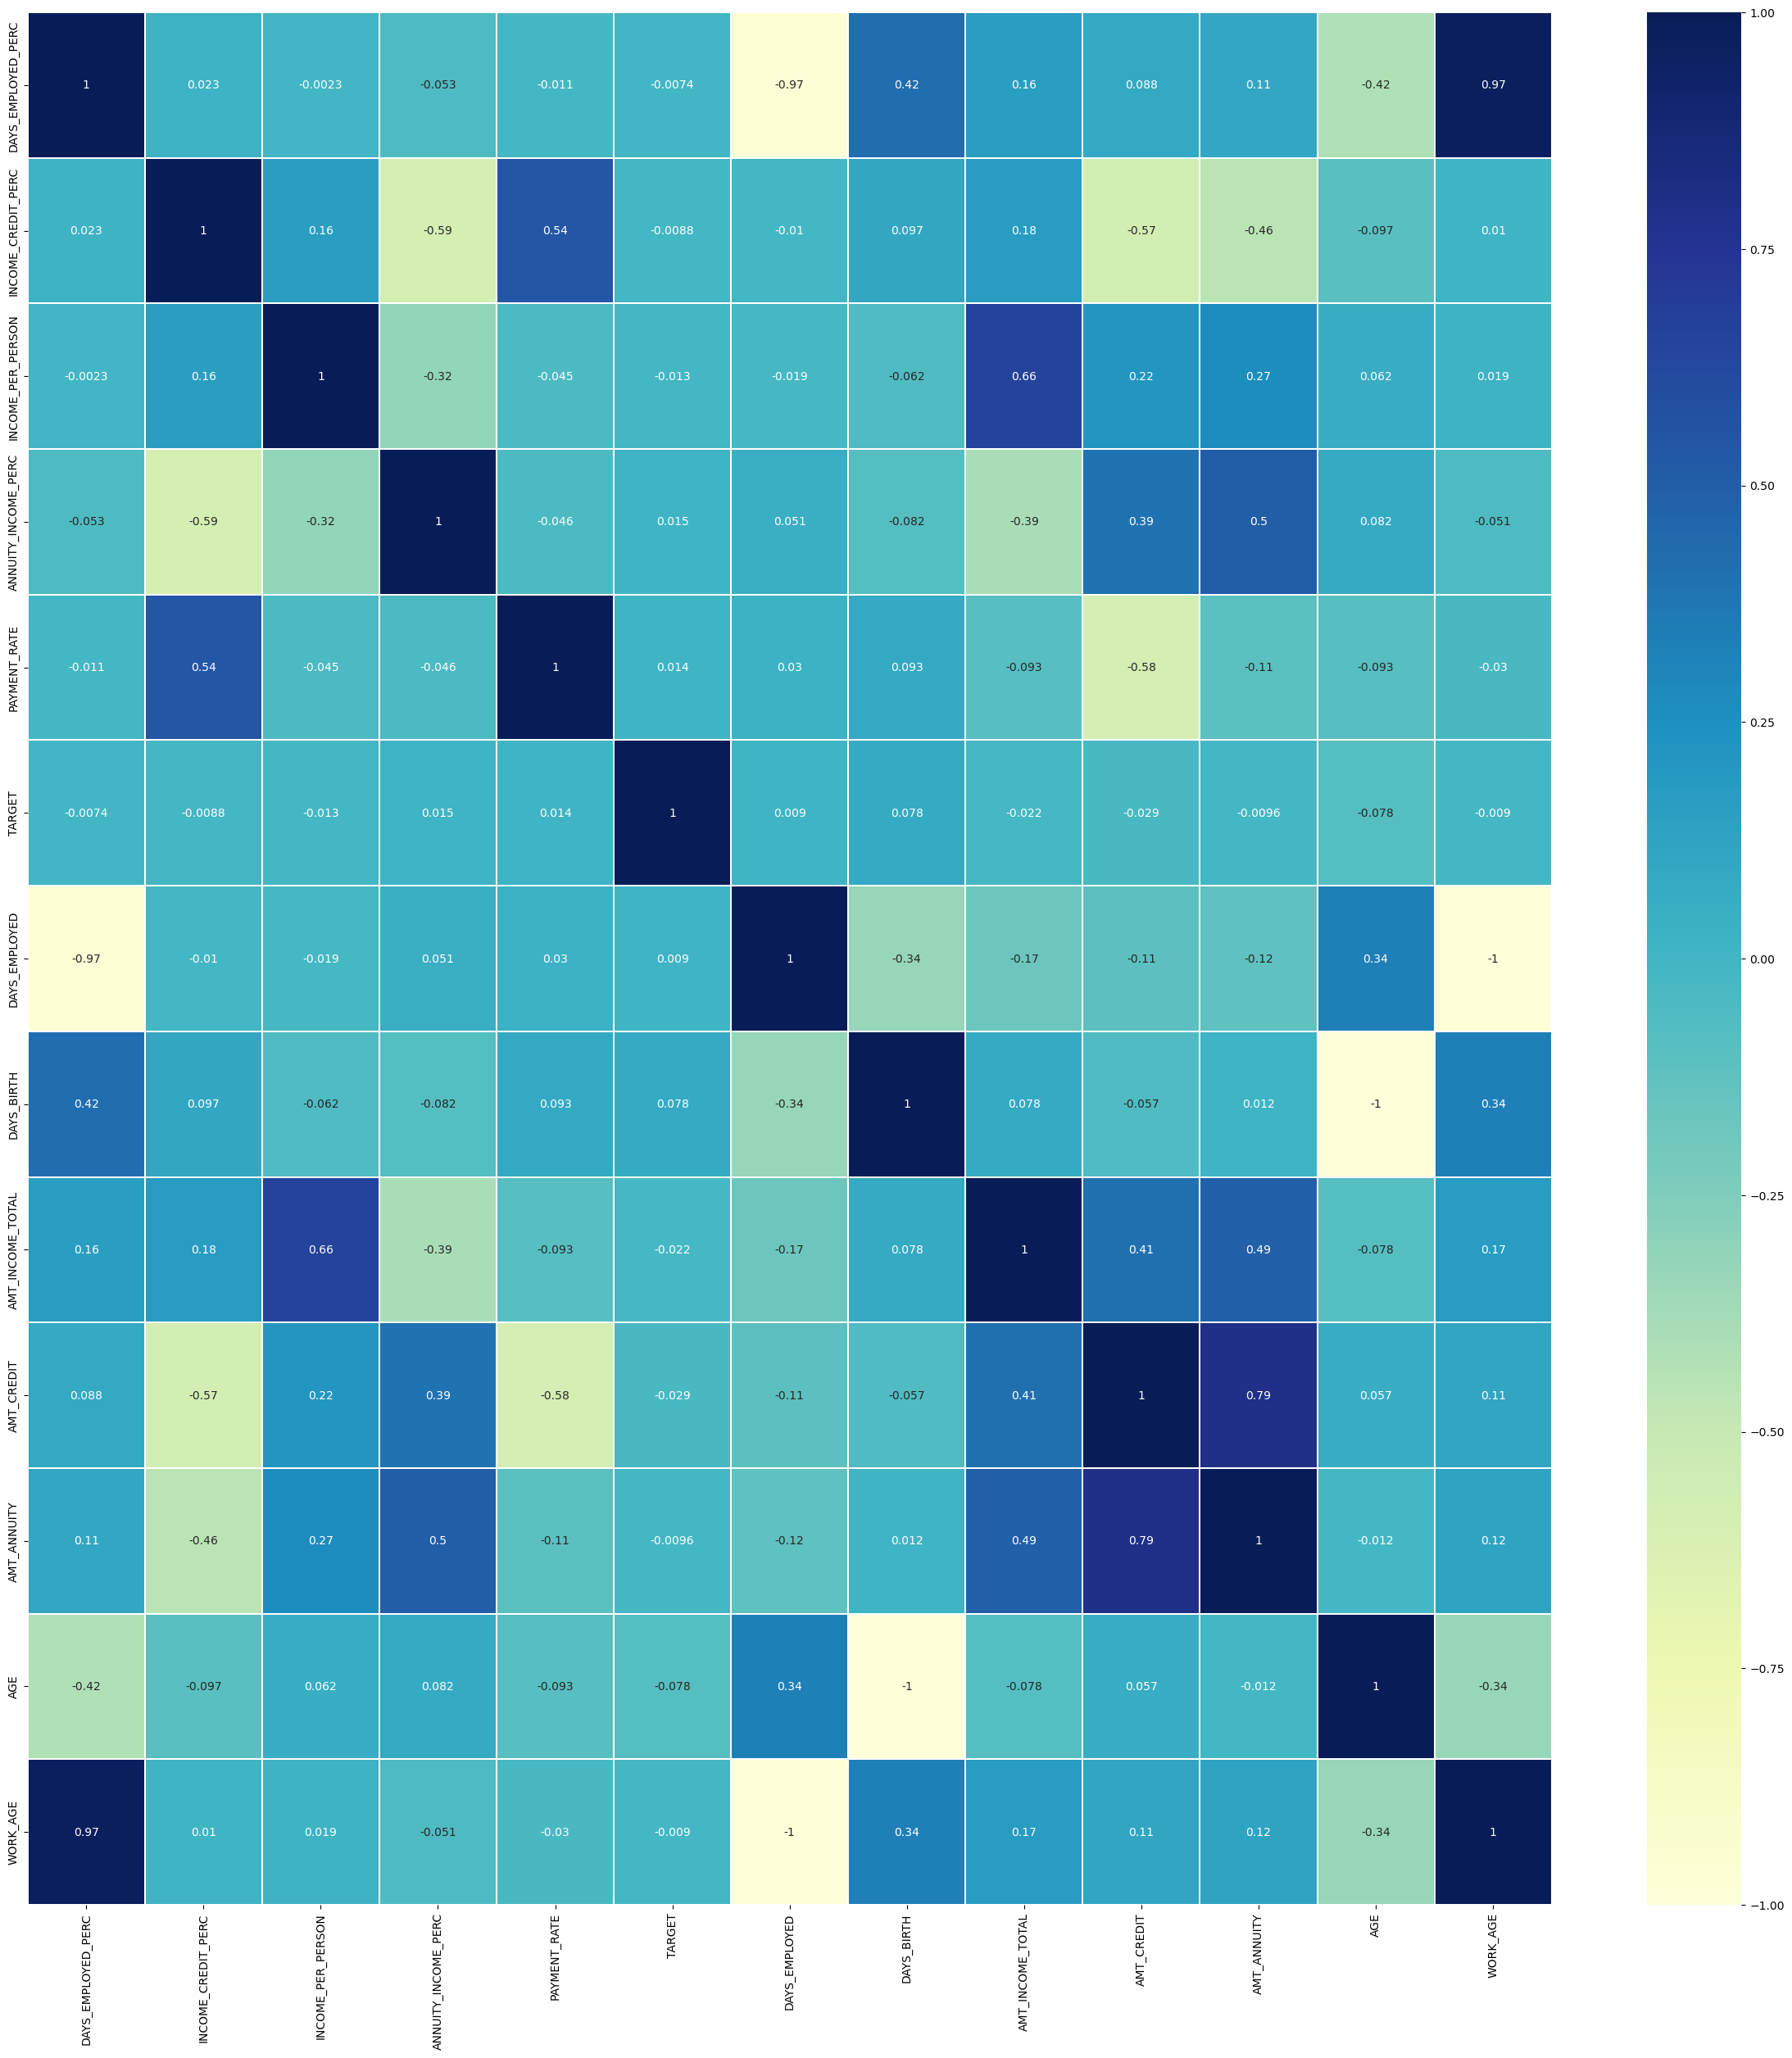

In [65]:
var = ['DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC',
      'PAYMENT_RATE', 'TARGET', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
      'AGE', 'WORK_AGE']

heatmap_correlation(train_new[var])

In [66]:
# Suppressions des variables trop fortement corrélés
train_new = train_new.drop(axis=1, columns=['CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_INCOME_TOTAL',
                                           'AMT_CREDIT', 'AMT_ANNUITY', 'WORK_AGE', 'DAYS_EMPLOYED', 'DAYS_BIRTH'])

In [67]:
train_new.shape

(307511, 71)

In [68]:
# Some simple new features (percentages)
test_new['DAYS_EMPLOYED_PERC'] = test_new['DAYS_EMPLOYED'] / test_new['DAYS_BIRTH']
test_new['INCOME_CREDIT_PERC'] = test_new['AMT_INCOME_TOTAL'] / test_new['AMT_CREDIT']
test_new['INCOME_PER_PERSON'] = test_new['AMT_INCOME_TOTAL'] / test_new['CNT_FAM_MEMBERS']
test_new['ANNUITY_INCOME_PERC'] = test_new['AMT_ANNUITY'] / test_new['AMT_INCOME_TOTAL']
test_new['PAYMENT_RATE'] = test_new['AMT_ANNUITY'] / test_new['AMT_CREDIT']
test_new['AGE'] = test_new['DAYS_BIRTH']/(-365)

In [69]:
# Enrengistrement des datasets après features engineering
test_new.to_csv(r'C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\new_test.csv', index=False)
train_new.to_csv(r'C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\new_train.csv', index=False)

In [70]:
test_new = test_new.drop(axis=1, columns=['CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_INCOME_TOTAL',
                                           'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_BIRTH'])
test_new.shape

(48744, 70)

# Normalization

In [71]:
x_train = train_new.drop("TARGET", axis = 1)
y = train_new['TARGET']

In [72]:
scaler=MinMaxScaler()
col = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC',
       'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'AGE',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

x_train[col] = pd.DataFrame(scaler.fit_transform(x_train[col]))
test_new[col] = pd.DataFrame(scaler.transform(test_new[col]))

In [73]:
x_train[col].shape

(307511, 69)

In [74]:
test_new[col].shape

(48744, 69)

In [75]:
# export du train et test pour la modélisation

train_new.to_csv(r"C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\data_model_train.csv", index=False)
test_new.to_csv(r"C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\API\data_model_test.csv", index=False)